In [1]:
from collections import defaultdict, OrderedDict, Counter
import numpy as np
import pandas as pd
from pathlib import Path
import textwrap
from tqdm import tqdm

%cd /home/drchajan/devel/python/FC/automated-fact-checking
%load_ext autoreload
%autoreload 2

from aic_nlp_utils.json import read_jsonl, read_json, write_json, write_jsonl
from aic_nlp_utils.encoding import nfc
from aic_nlp_utils.fever import fever_detokenize

from factsearch.mark import EmphasizeClaimWords

# from evaluation.document_retrieval import collect_eval_data, retriever_score
# from evaluation.nli import LABEL_NUM, LABEL_STR, load_rte_model, evaluate_examples, evaluate_all_nli
# from evaluation.fcheck_pipeline import read_fever_db, collect_scores_full, evaluate_full, extract_texts_ctk, InputSplitter

/home/drchajan/devel/python/FC/automated-fact-checking


/home/drchajan/devel/python/FC/aic-nlp-utils/aic_nlp_utils/json.py:2: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


This notebook covers evaluation of fact-checking pipeline. It is based on LREV2022 notebook.

In [2]:
# original not calibrated versions (BAD, but does not matter for RND)
# PVI_DIR_CS = '/mnt/data/factcheck/wiki/cs/20230801/qacg/nli/PAV-ner-CNEC/mt5-large_all-cp126k/mt5-large_all-cp156k/pvi'
# PVI_DIR_FCS= '/mnt/data/factcheck/NLI/csfever_nli_cls/pvi'
# PVI_DIR_EN = '/mnt/data/factcheck/wiki/en/20230801/qacg/nli/stanza/mt5-large_all-cp126k/mt5-large_all-cp156k/pvi'
# PVI_DIR_FEN = '/mnt/data/factcheck/NLI/nli_fever_cls/pvi'

PVI_DIR_CS = '/mnt/data/factcheck/wiki/cs/20230801/qacg/nli/PAV-ner-CNEC/mt5-large_all-cp126k/mt5-large_all-cp156k/pvi_calibrated'
PVI_DIR_FCS= '/mnt/data/factcheck/NLI/csfever_nli_cls/pvi_calibrated'
PVI_DIR_EN = '/mnt/data/factcheck/wiki/en/20230801/qacg/nli/stanza/mt5-large_all-cp126k/mt5-large_all-cp156k/pvi_calibrated'
PVI_DIR_FEN = '/mnt/data/factcheck/NLI/nli_fever_cls/pvi_calibrated'
PVI_DIR_CS_FS = "/mnt/data/factcheck/wiki/cs/20230801/qacg/nli/PAV-ner-CNEC/mt5-large_all-cp126k/mt5-large_all-cp156k/pvi_fever_size_calibrated"
PVI_DIR_EN_FS = "/mnt/data/factcheck/wiki/en/20230801/qacg/nli/stanza/mt5-large_all-cp126k/mt5-large_all-cp156k/pvi_fever_size_calibrated"


# QACG Examples

In [3]:
def import_corpus(corpus_file):
    # it already has correct format
    raw = read_jsonl(corpus_file, show_progress=True)
    for e in raw:
        e["id"] = nfc(e["id"])
        e["did"] = nfc(e["did"])
        e["text"] = nfc(e["text"])
    return raw

def generate_original_id2pid_mapping(corpus):
    original_id2pid = {}
    for pid, r in enumerate(corpus):
        original_id = r["id"]
        # assert original_id not in original_id2pid, f"original ID not unique! {original_id}"
        if original_id in original_id2pid:
            print(f"original ID not unique! {pid} {original_id}, previous pid: {original_id2pid[original_id]}")
        original_id2pid[original_id] = pid
    return original_id2pid

LANG = "en"
DATE = "20230801"

QG_DIR = "mt5-large_all-cp126k"
QACG_DIR = "mt5-large_all-cp156k"

WIKI_ROOT = f"/mnt/data/factcheck/wiki/{LANG}/{DATE}"
WIKI_CORPUS = f"{WIKI_ROOT}/paragraphs/{LANG}wiki-{DATE}-paragraphs.jsonl"

corpus = import_corpus(WIKI_CORPUS)
original_id2pid = generate_original_id2pid_mapping(corpus)

0.00it [00:00, ?it/s]

KeyboardInterrupt: 

In [ ]:
def show_example(root, model_names, split, corpus, original_id2pid):
    claims_sup = read_json(Path(root, "claim", model_names, f"{split}_support.json"))
    claims_ref = read_json(Path(root, "claim", model_names, f"{split}_refute.json"))
    claims_nei = read_json(Path(root, "claim", model_names, f"{split}_nei.json"))
    for sup_id, v in claims_sup.items():
        sup_text = corpus[original_id2pid[sup_id]]["text"]
        nei_claims = claims_nei[sup_id]
        # if len(v) >= 5 and len(sup_text) < 500 and len(nei_claims) > 0:
        if len(v) >= 5 and len(sup_text) > 500 and len(sup_text) < 700 and len(nei_claims) > 0:
            print(sup_id, len(sup_text))

    # sup_id = "Zabriskie_Point_(film)_1"
    # sup_id = "The_Independent_1"
    # sup_id = "Johnny_Hallyday_1"

    sup_id = "Cactus_2"
    # sup_id = "Richard_Ayoade_4"
    # sup_id = "Rihanna_13"
    # sup_id = "Polární_stanice_2"
    # sup_id = "USS_Indianapolis_(CA-35)_2"

    sup_claims = claims_sup[sup_id]
    ref_claims = claims_ref[sup_id]
    nei_claims = claims_nei[sup_id]
    sup_text = corpus[original_id2pid[sup_id]]["text"]
    print()
    print(textwrap.fill(sup_text))
    print()
    for k, v in sup_claims.items():
        print(k)
        print("\tSUP: ", v)
        print("\tREF: ", ref_claims.get(k, "MISSING"))

    for k, v in nei_claims.items():
        print("\tNEI: ", v)

ROOT_CS = "/mnt/data/factcheck/wiki/cs/20230801/qacg"
MODEL_NAMES = "PAV-ner-CNEC/mt5-large_all-cp126k/mt5-large_all-cp156k"

show_example(ROOT_CS, MODEL_NAMES, "train", corpus, original_id2pid)

In [3]:
def show_pvi_examples(k=5):
    # src_jsonl = "/mnt/data/factcheck/wiki/en/20230801/qacg/nli/stanza/mt5-large_all-cp126k/mt5-large_all-cp156k/pvi_calibrated/test_balanced_annotated_random_sup.jsonl"
    src_jsonl = "/mnt/data/factcheck/wiki/en/20230801/qacg/nli/stanza/mt5-large_all-cp126k/mt5-large_all-cp156k/pvi_calibrated/test_balanced_annotated_random_ref.jsonl"
    # src_jsonl = "/mnt/data/factcheck/wiki/en/20230801/qacg/nli/stanza/mt5-large_all-cp126k/mt5-large_all-cp156k/pvi_calibrated/test_balanced_annotated_random_nei.jsonl"
    recs = read_jsonl(src_jsonl)
    recs = sorted(recs, key = lambda r: float(r["PVI"]))
    s2l = {'s': 'SUP', 'r': 'REF', 'n': 'NEI', 'w': 'WRONG'}
    for r in recs[:k]:
        print(r['claim'])
        print(f"{s2l[r['label']]} => {s2l[r['annotated_label']]},PVI: {r['PVI']}")
        print(textwrap.fill(r['context']))
        print("--------------------------")
    # return recs

show_pvi_examples()

The special elections held in Maryland were on January 1, 1823.
REF => SUP,PVI: -5.3625727
1823 Maryland's 5th congressional district special elections  Special
elections were held in Maryland's congressional district on January 1,
1823, to fill vacancies in the 17th and 18th Congresses caused by the
resignation of Samuel Smith (DR) after being elected to the Senate.
Smith had been re-elected to the House in October. His resignation
therefore created vacancies both in the remainder of the 17th Congress
and in the 18th Congress.  1823 Maryland's 5th congressional district
special elections  Election to the 17th Congress.  McKim took his seat
on January 8, 1823  References.
--------------------------
The Confederate volunteer companies occupied the Civil War.
REF => WRONG,PVI: -3.075924
Oglethorpe Barracks  Meteorological observations continued through
December 1850; American soldiers probably left the post at the end of
the year. In 1852, City of Savannah proposed to purchase the site f

In [35]:
recs = read_jsonl("/mnt/data/factcheck/wiki/en/20230801/qacg/nli/stanza/mt5-large_all-cp126k/mt5-large_all-cp156k/test_balanced.jsonl") 

(array([2.7024e+04, 0.0000e+00, 0.0000e+00, 6.6100e+02, 0.0000e+00,
        0.0000e+00, 2.6000e+01, 0.0000e+00, 0.0000e+00, 4.0000e+00]),
 array([1. , 1.3, 1.6, 1.9, 2.2, 2.5, 2.8, 3.1, 3.4, 3.7, 4. ]),
 <BarContainer object of 10 artists>)

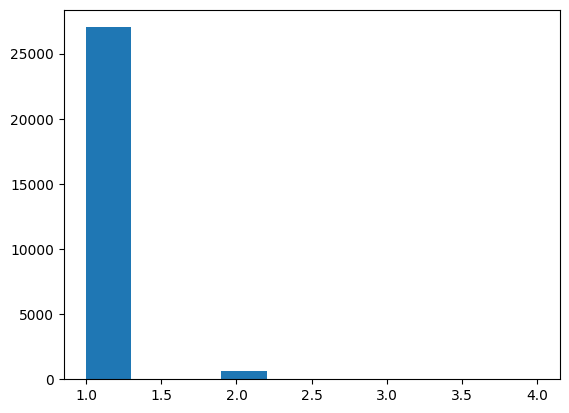

In [43]:
import matplotlib.pyplot as plt
plt.hist(Counter([(r['claim'], r["label"]) for r in recs]).values())

In [64]:
def show_nli_classification_for_claim(claim):
    claim_jsonl = "/mnt/data/factcheck/wiki/en/20230801/qacg/nli/stanza/mt5-large_all-cp126k/mt5-large_all-cp156k/test_balanced.jsonl"
    nli_pred_json = "/mnt/data/factcheck/models/drchajan_EXP/qacg/nli/deepset/xlm-roberta-large-squad2_sum_cs_en_pl_sk-20230801_balanced_lr1e-6/checkpoint-321184/predictions_wiki-en_sum_test.json"
    # model_name = "/home/drchajan/devel/python/FC/Zero-shot-Fact-Verification/experiments/nli/deepset/xlm-roberta-large-squad2_sum_cs_en_pl_sk-20230801_balanced_lr1e-6/checkpoint-321184"
    claims = read_jsonl(claim_jsonl)
    nli = read_json(nli_pred_json)
    assert len(claims) == len(nli["pred_classes"])
    s2l = {'s': 'SUP', 'r': 'REF', 'n': 'NEI', 'w': 'WRONG'}
    s2idx = {'n': 0, 'r': 1, 's': 2}

    targets = [c["label"] for c in claims]
    assert all(t1 == t2 for t1, t2 in zip(targets, nli["targets"]))
    # preds = nli['pred_classes']

    # from sklearn.metrics import confusion_matrix
    # print(nli["cmatrix"])
    # return confusion_matrix(targets, preds, labels=['s', 'r', 'n'])

    for idx, c in enumerate(claims):
        if c["claim"] == claim:
            pred_cls = nli["pred_classes"][idx]
            pred = s2l[pred_cls]
            logits = nli["pred_probs"][idx]
            probs = np.exp(logits)/sum(np.exp(logits))
            conf = 100 * probs[s2idx[pred_cls]]
            print(claim)
            print(f"IDX = {idx}, target: {s2l[c['label']]}, model: {pred} ({conf}%)")
            # print(textwrap.fill(c["context"]))
            print("----------------------------------------")

show_nli_classification_for_claim('Verkhnii Turiv belonged to Turka Raion until July 2020.')
show_nli_classification_for_claim('The special elections held in Maryland were on January 1, 1823.')
show_nli_classification_for_claim('The Confederate volunteer companies occupied the Civil War.')
show_nli_classification_for_claim('Meredith was the candidate for the Republican nomination in 1972.')

Verkhnii Turiv belonged to Turka Raion until July 2020.
IDX = 7904, target: SUP, model: SUP (61.087142658401575%)
----------------------------------------
Verkhnii Turiv belonged to Turka Raion until July 2020.
IDX = 20170, target: SUP, model: SUP (61.087142658401575%)
----------------------------------------
The special elections held in Maryland were on January 1, 1823.
IDX = 22017, target: REF, model: SUP (91.81252147267698%)
----------------------------------------
The Confederate volunteer companies occupied the Civil War.
IDX = 1057, target: SUP, model: SUP (92.590868023989%)
----------------------------------------
The Confederate volunteer companies occupied the Civil War.
IDX = 28134, target: REF, model: SUP (92.590868023989%)
----------------------------------------
Meredith was the candidate for the Republican nomination in 1972.
IDX = 18329, target: NEI, model: REF (97.8656137871335%)
----------------------------------------


# QACG Data Stats

In [3]:
def qacg_data_stats(dataset_lst):
    results = []
    for dataset in dataset_lst:
        name = dataset["name"]
        dir_ = dataset["dir"]
        res = {"name": name}
        for split in dataset["splits"]:
            split_name = split["name"]
            recs = []
            
            for file_ in split["files"]:
                recs += read_jsonl(Path(dir_, file_))
            if "labels" in split:
                for label in split["labels"]:
                    res[split_name + "_" + label] = len([True for r in recs if r['label'] == label])
            else:
                res[split_name] = len(recs)
        results.append(res)
    return pd.DataFrame(results)



QACG_SPLITS = [
    {"name": "train", "files": ["train_balanced.jsonl"]},
    {"name": "dev", "files": ["dev_balanced.jsonl"]},
    {"name": "test", "files": ["test_balanced.jsonl"]},
    {"name": "all", "files": ["train_balanced.jsonl", "dev_balanced.jsonl", "test_balanced.jsonl"]},
    {"name": "all", "files": ["train_balanced.jsonl", "dev_balanced.jsonl", "test_balanced.jsonl"], "labels": ["s", "r", "n"]}
]
dataset_lst = [
    {"name": "CS", "dir": "/mnt/data/factcheck/wiki/cs/20230801/qacg/splits/PAV-ner-CNEC/mt5-large_all-cp126k/mt5-large_all-cp156k", "splits": QACG_SPLITS},
    {"name": "EN", "dir": "/mnt/data/factcheck/wiki/en/20230801/qacg/splits/stanza/mt5-large_all-cp126k/mt5-large_all-cp156k", "splits": QACG_SPLITS},
    {"name": "PL", "dir": "/mnt/data/factcheck/wiki/pl/20230801/qacg/splits/stanza/mt5-large_all-cp126k/mt5-large_all-cp156k", "splits": QACG_SPLITS},
    {"name": "SK", "dir": "/mnt/data/factcheck/wiki/sk/20230801/qacg/splits/crabz_slovakbert-ner/mt5-large_all-cp126k/mt5-large_all-cp156k", "splits": QACG_SPLITS},
    {"name": "MIX", "dir": "/mnt/data/factcheck/wiki/cs_en_pl_sk/20230801/qacg/splits", "splits": QACG_SPLITS},
    {"name": "SUM", "dir": "/mnt/data/factcheck/wiki/sum_cs_en_pl_sk/20230801/qacg/splits", "splits": QACG_SPLITS},
]

df = qacg_data_stats(dataset_lst)
df

KeyboardInterrupt: 

In [5]:
print(df.to_latex(float_format="%.1f", index=False))

\begin{tabular}{lrrrrrrr}
\toprule
name &   train &    dev &   test &     all &  all\_s &  all\_r &  all\_n \\
\midrule
  CS &  295209 &  30087 &  28440 &  353736 & 117912 & 117912 & 117912 \\
  EN &  295209 &  30087 &  28440 &  353736 & 117912 & 117912 & 117912 \\
  PL &  295209 &  30087 &  28440 &  353736 & 117912 & 117912 & 117912 \\
  SK &  295209 &  30087 &  28440 &  353736 & 117912 & 117912 & 117912 \\
 MIX &  295209 &  30087 &  28440 &  353736 & 118039 & 117640 & 118057 \\
 SUM & 1180836 & 120348 & 113760 & 1414944 & 471648 & 471648 & 471648 \\
\bottomrule
\end{tabular}



/tmp/ipykernel_3539968/1031443201.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df.to_latex(float_format="%.1f", index=False))


In [13]:
def qacg_claim_data_stats(dataset_lst):
    results = []
    for dataset in dataset_lst:
        name = dataset["name"]
        res = {"name": name}
        for label in dataset["labels"]:
            label_name = label["name"]
            fnames = label["files"]
            cnt = 0
            for fname in fnames:
                recs = read_json(Path(dataset["dir"], fname))
                for k, v in recs.items():
                    cnt += len(v)
            res[label_name] = cnt
        res["total"] = res["sup"] + res["ref"] + res["nei"]
        res["sup"] *= 100/res["total"]
        res["ref"] *= 100/res["total"]
        res["nei"] *= 100/res["total"]
        results.append(res)
    return pd.DataFrame(results)

QACG_LABELS = [
    {"name": "sup", "files": ["train_support.json", "dev_support.json", "test_support.json"]},
    {"name": "ref", "files": ["train_refute.json", "dev_refute.json", "test_refute.json"]},
    {"name": "nei", "files": ["train_nei.json", "dev_nei.json", "test_nei.json"]},
]

dataset_lst = [{"name": "CS", "dir": "/mnt/data/factcheck/wiki/cs/20230801/qacg/claim/PAV-ner-CNEC/mt5-large_all-cp126k/mt5-large_all-cp156k", "labels": QACG_LABELS},
    {"name": "EN", "dir": "/mnt/data/factcheck/wiki/en/20230801/qacg/claim/stanza/mt5-large_all-cp126k/mt5-large_all-cp156k", "labels": QACG_LABELS},
    {"name": "PL", "dir": "/mnt/data/factcheck/wiki/en/20230801/qacg/claim/stanza/mt5-large_all-cp126k/mt5-large_all-cp156k", "labels": QACG_LABELS},
    {"name": "SK", "dir": "/mnt/data/factcheck/wiki/sk/20230801/qacg/claim/crabz_slovakbert-ner/mt5-large_all-cp126k/mt5-large_all-cp156k", "labels": QACG_LABELS},
]


df = qacg_claim_data_stats(dataset_lst)
df

,name,sup,ref,nei,total
0,CS,38.339257,36.480159,25.180584,618687
1,EN,38.997522,34.854809,26.147669,628622
2,PL,38.997522,34.854809,26.147669,628622
3,SK,40.245262,38.580790,21.173948,556873


In [14]:
print(df.to_latex(float_format="%.1f", index=False))

\begin{tabular}{lrrrr}
\toprule
name &  sup &  ref &  nei &  total \\
\midrule
  CS & 38.3 & 36.5 & 25.2 & 618687 \\
  EN & 39.0 & 34.9 & 26.1 & 628622 \\
  PL & 39.0 & 34.9 & 26.1 & 628622 \\
  SK & 40.2 & 38.6 & 21.2 & 556873 \\
\bottomrule
\end{tabular}



/tmp/ipykernel_3539968/1031443201.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df.to_latex(float_format="%.1f", index=False))


In [16]:
def count_triples(cfgs):
    for name, cfg in cfgs.items():
        cnt = 0
        for fname in cfg["files"]:
            cnt += len(read_jsonl(Path(cfg["dir"], fname)))
        print(f"{name}: {cnt}")

QACG_TRIPLES = [
    "trn_triples_nway128_evidence+anserini_balanced_shuf.jsonl",
    "dev_triples_nway128_evidence+anserini_balanced_shuf.jsonl",
    "tst_triples_nway128_evidence+anserini_balanced_shuf.jsonl",
]

FEVER_TRIPLES = [
    "train_triples_nway128_evidence+anserini.jsonl",
    "dev_triples_nway128_evidence+anserini.jsonl",
    "test_triples_nway128_evidence+anserini.jsonl",
]

cfgs = {
    "CS": {"dir": "/mnt/data/factcheck/wiki/cs/20230801/colbertv2/qacg/triples/PAV-ner-CNEC/mt5-large_all-cp126k/mt5-large_all-cp156k", "files": QACG_TRIPLES},
    "EN": {"dir": "/mnt/data/factcheck/wiki/en/20230801/colbertv2/qacg/triples/stanza/mt5-large_all-cp126k/mt5-large_all-cp156k", "files": QACG_TRIPLES},
    "PL": {"dir": "/mnt/data/factcheck/wiki/pl/20230801/colbertv2/qacg/triples/stanza/mt5-large_all-cp126k/mt5-large_all-cp156k", "files": QACG_TRIPLES},
    "SK": {"dir": "/mnt/data/factcheck/wiki/sk/20230801/colbertv2/qacg/triples/crabz_slovakbert-ner/mt5-large_all-cp126k/mt5-large_all-cp156k", "files": QACG_TRIPLES},
    "MIX": {"dir": "/mnt/data/factcheck/wiki/cs_en_pl_sk/20230801/colbertv2/qacg/triples", "files": QACG_TRIPLES},
    "SUM": {"dir": "/mnt/data/factcheck/wiki/sum_cs_en_pl_sk/20230801/colbertv2/qacg/triples", "files": QACG_TRIPLES},
    
    "FCZ": {"dir": "/mnt/data/factcheck/fever/data-cs-lrev/colbertv2/triples", "files": FEVER_TRIPLES},
    "FEN": {"dir": "/mnt/data/factcheck/fever/data-en-lrev/colbertv2/triples", "files": FEVER_TRIPLES},
}

count_triples(cfgs)
    

CS: 225684
EN: 223456
PL: 219620
SK: 219962
MIX: 223385
SUM: 888722
FCZ: 84803
FEN: 123139


# Document Retrieval
Based on https://gitlab.fel.cvut.cz/factchecking/experimental-martin/-/blob/master/evaluation/doc_retr_evaluation.ipynb

## Wikipedias

In [2]:
FDIR_CS = "/mnt/data/factcheck/wiki/cs/20230801"
FDIR_EN = "/mnt/data/factcheck/wiki/en/20230801"
FDIR_PL = "/mnt/data/factcheck/wiki/pl/20230801"
FDIR_SK = "/mnt/data/factcheck/wiki/sk/20230801"

FDIR_FCS = "/mnt/data/factcheck/fever/data-cs-lrev"
FDIR_FEN = "/mnt/data/factcheck/fever/data-en-lrev"

def CS(f, fname="predictions.jsonl"): 
    return Path(FDIR_CS, f, fname)

def EN(f, fname="predictions.jsonl"):
    return Path(FDIR_EN, f, fname)

def PL(f, fname="predictions.jsonl"):
    return Path(FDIR_PL, f, fname)

def SK(f, fname="predictions.jsonl"):
    return Path(FDIR_SK, f, fname)

def FCS(f, fname="predictions.jsonl"): 
    return Path(FDIR_FCS, f, fname)

def FEN(f, fname="predictions.jsonl"): 
    return Path(FDIR_FEN, f, fname)

def convert_anserini_for_colbertv2_predictions(src, dst):
    # let's use anserini retrieved pages used for colbertv2 hard negatives
    # just rename keys
    data = read_jsonl(src)
    for r in data:
        r["predicted_pages"] = r["retrieved"]
        del r["retrieved"]
    write_jsonl(dst, data, mkdir=True)


# RUN once
# convert_anserini_for_colbertv2_predictions(
#     Path(FDIR_CS, "anserini/retrieved/PAV-ner-CNEC/mt5-large_all-cp126k/mt5-large_all-cp156k/test_balanced.jsonl"),
#     Path(FDIR_CS, "anserini/predictions/qacg/predictions.jsonl"))

# convert_anserini_for_colbertv2_predictions(
#     Path(FDIR_EN, "anserini/retrieved/stanza/mt5-large_all-cp126k/mt5-large_all-cp156k/test_balanced.jsonl"),
#     Path(FDIR_EN, "anserini/predictions/qacg/predictions.jsonl"))

# convert_anserini_for_colbertv2_predictions(
#     Path(FDIR_PL, "anserini/retrieved/stanza/mt5-large_all-cp126k/mt5-large_all-cp156k/test_balanced.jsonl"),
#     Path(FDIR_PL, "anserini/predictions/qacg/predictions.jsonl"))

# convert_anserini_for_colbertv2_predictions(
#     Path(FDIR_SK, "anserini/retrieved/crabz_slovakbert-ner/mt5-large_all-cp126k/mt5-large_all-cp156k/test_balanced.jsonl"),
#     Path(FDIR_SK, "anserini/predictions/qacg/predictions.jsonl"))

This is a rewriten version of the evaluation. It does not care about evidence sets by different annotators. It implements a straightforward MRR where all evidence sets are summed (union). It is simpler, faster and the numbers are very similar...

QACG datasets have always a single evidence document only which would most likely favor them when compared to FEVER...

In [3]:
def compute_stats(cfgs, ks, rounding=2, stats=["MRR", "P"]):
    stats = [s.upper() for s in stats]
    assert all(s in set(["MRR", "P"]) for s in stats)
    def filter_and_check(recs):
        nrecs = []
        allowed_labels = set(["S", "R", "N", "SUPPORTS", "REFUTES", "NOT ENOUGH INFO"])
        for r in recs:
            label = r["label"].upper()
            assert label in allowed_labels, label
            if label not in ["N", "NOT ENOUGH INFO"]:
                nrecs.append(r)
        return nrecs


    def extract_evidence(evidence_rec):
        if isinstance(evidence_rec[0], list):
            all_ev = set()
            for eset in evidence_rec:
                for e in eset:
                    assert len(e) in [4, 5], e
                    all_ev.add(e[2])
            evidence_rec = list(all_ev)
        assert len(evidence_rec) > 0, evidence_rec
        assert isinstance(evidence_rec[0], str), evidence_rec
        return evidence_rec
        
    def compute_mrr(preds, ev, k):
        ev = set(ev)
        for i in range(len(preds[:k])):
            if preds[i] in ev:
                return 1 / (i+1)
        return 0.0
    
    def compute_p(preds, ev, k):
        ev = set(ev)
        kpreds = preds[:k]
        # assert len(kpreds) > 0, f"k={k}, ev={ev}, kpreds({len(kpreds)})={kpreds}"
        if len(kpreds) == 0:
            return 0.0
        precision = np.sum([p in ev for p in kpreds])/k
        # if precision == 0.0:
        #     print(ev, preds)
        return precision

    for cfg in cfgs:
        assert Path(cfg["pred"]).is_file(), (cfg["model"], cfg["pred"])
    
    results = []
    for cfg in tqdm(cfgs):
        recs = read_jsonl(cfg["pred"])
        recs = filter_and_check(recs)
        n = len(recs)
        max_k = cfg.get("max_k")

        mrrs = defaultdict(list)
        ps = defaultdict(list)
        for r in recs:
            preds = r["predicted_pages"]
            evidence = extract_evidence(r["evidence"])
            for k in ks:
                if max_k is None or k <= max_k:
                    mrrs[k].append(compute_mrr(preds, evidence, k))
                    ps[k].append(compute_p(preds, evidence, k))

        result = {"name": cfg["model"]}
        for k in ks:
            if k in mrrs:
                mrr = 100 * np.sum(mrrs[k])/n
                p = 100 * np.sum(ps[k])/n
            else:
                mrr = np.nan
                p = np.nan
            if "MRR" in stats:
                result[f"MRR@{k}"] = mrr
            if "P" in stats:
                result[f"P@{k}"] = p
        results.append(result)
    df = round(pd.DataFrame(results), rounding)
    return df

cfgs = [
    {"model": "Anserini QACG-CS", "pred": CS("anserini/predictions/qacg/test_balanced_shuf")},
    {"model": "ColBERT QACG-CS", "pred": CS("colbertv2/qacg/predictions/qacg/bert-base-multilingual-cased/nway32_anserini_balanced_shuf_231029_190928/colbert-best_eval/2bits")},
    {"model": "ColBERT QACG-MIX/QACG-CS", "pred": CS("colbertv2/qacg/predictions/qacg/cs_en_pl_sk/bert-base-multilingual-cased/nway32_anserini_balanced_shuf_231029_200439/colbert-best_eval/2bits")},
    {"model": "ColBERT QACG-SUM/QACG-CS", "pred": CS("colbertv2/qacg/predictions/qacg/sum_cs_en_pl_sk/bert-base-multilingual-cased/nway32_anserini_balanced_shuf_231029_200426/colbert-best_eval/2bits")},
    {"model": "ColBERT FCZ/QACG-CS", "pred": CS("colbertv2/qacg/predictions/csfever/bert-base-multilingual-cased/nway32_anserini_231028_093104/colbert-best_eval/2bits")},
    
    {"model": "Anserini QACG-EN", "pred": EN("anserini/predictions/qacg/test_balanced_shuf")},
    {"model": "ColBERT QACG-EN", "pred": EN("colbertv2/qacg/predictions/qacg/bert-base-multilingual-cased/nway32_anserini_balanced_shuf_231029_190827/colbert-best_eval/2bits")},
    {"model": "ColBERT QACG-MIX/QACG-EN", "pred": EN("colbertv2/qacg/predictions/qacg/cs_en_pl_sk/bert-base-multilingual-cased/nway32_anserini_balanced_shuf_231029_200439/colbert-best_eval/2bits")},
    {"model": "ColBERT QACG-SUM/QACG-EN", "pred": EN("colbertv2/qacg/predictions/qacg/sum_cs_en_pl_sk/bert-base-multilingual-cased/nway32_anserini_balanced_shuf_231029_200426/colbert-best_eval/2bits")},
    {"model": "ColBERT FEN/QACG-EN", "pred": EN("colbertv2/qacg/predictions/enfever/bert-base-multilingual-cased/nway32_anserini_231028_093101/colbert-best_eval/2bits")},
    
    {"model": "Anserini QACG-PL", "pred": PL("anserini/predictions/qacg/test_balanced_shuf")},
    {"model": "ColBERT QACG-PL", "pred": PL("colbertv2/qacg/predictions/qacg/bert-base-multilingual-cased/nway32_anserini_balanced_shuf_231029_190755/colbert-best_eval/2bits")},
    {"model": "ColBERT QACG-MIX/QACG-PL", "pred": PL("colbertv2/qacg/predictions/qacg/cs_en_pl_sk/bert-base-multilingual-cased/nway32_anserini_balanced_shuf_231029_200439/colbert-best_eval/2bits")},
    {"model": "ColBERT QACG-SUM/QACG-PL ", "pred": PL("colbertv2/qacg/predictions/qacg/sum_cs_en_pl_sk/bert-base-multilingual-cased/nway32_anserini_balanced_shuf_231029_200426/colbert-best_eval/2bits")},

    {"model": "Anserini QACG-SK", "pred": SK("anserini/predictions/qacg/test_balanced_shuf")},
    {"model": "ColBERT QACG-SK", "pred": SK("colbertv2/qacg/predictions/qacg/bert-base-multilingual-cased/nway32_anserini_balanced_shuf_231029_180011/colbert-best_eval/2bits")},
    {"model": "ColBERT QACG-MIX/QACG-PL", "pred": SK("colbertv2/qacg/predictions/qacg/cs_en_pl_sk/bert-base-multilingual-cased/nway32_anserini_balanced_shuf_231029_200439/colbert-best_eval/2bits")},
    {"model": "ColBERT QACG-SUM/QACG-PL", "pred": SK("colbertv2/qacg/predictions/qacg/sum_cs_en_pl_sk/bert-base-multilingual-cased/nway32_anserini_balanced_shuf_231029_200426/colbert-best_eval/2bits")},
    
    {"model": "Anserini-LREV FCZ", "pred": "/mnt/data/factcheck/fever/fever-data-deepl/predictions/test_anserini_k500_0.9_0.9_fever_deepl_nfc.jsonl"},
    {"model": "ColBERT-LREV FCZ", "pred": "/mnt/data/factcheck/fever/fever-data-deepl/predictions/test_colbert_fever_deepl_k500_nonverifiable_included.jsonl"},
    {"model": "ColBERT FCZ", "pred": FCS("colbertv2/predictions/csfever/bert-base-multilingual-cased/nway32_anserini_231028_093104/colbert-best_eval/2bits")},
    {"model": "ColBERT QACG-MIX/FCZ", "pred": FCS("colbertv2/predictions/cs_en_pl_sk/bert-base-multilingual-cased/nway32_anserini_balanced_shuf_231029_200439/colbert-best_eval/2bits")},
    {"model": "ColBERT QACG-SUM/FCZ", "pred": FCS("colbertv2/predictions/sum_cs_en_pl_sk/bert-base-multilingual-cased/nway32_anserini_balanced_shuf_231029_200426/colbert-best_eval/2bits")},

    {"model": "Anserini-LREV FEN", "pred": "/mnt/data/factcheck/fever/data-en-lrev/predictions/paper_test/anserini/k500_0.6_0.5.jsonl", "new_format": False},
    {"model": "ColBERT-LREV FEN", "pred": "/mnt/data/factcheck/fever/data-en-lrev/predictions/paper_test/colbert/enfever_lrev128/k500.jsonl", "new_format": False},
    {"model": "ColBERT FEN", "pred": FEN("colbertv2/predictions/enfever/bert-base-multilingual-cased/nway32_anserini_231028_093101/colbert-best_eval/2bits")},
    {"model": "ColBERT QACG-MIX/FEN", "pred": FEN("colbertv2/predictions/cs_en_pl_sk/bert-base-multilingual-cased/nway32_anserini_balanced_shuf_231029_200439/colbert-best_eval/2bits")},
    {"model": "ColBERT QACG-SUM/FEN", "pred": FEN("colbertv2/predictions/sum_cs_en_pl_sk/bert-base-multilingual-cased/nway32_anserini_balanced_shuf_231029_200426/colbert-best_eval/2bits")},
]

# df = compute_stats(cfgs, ks=[1, 2, 5, 10, 20])
# df

In [10]:
CS("colbertv2/qacg/predictions/qacg/sum_cs_en_pl_sk/bert-base-multilingual-cased/nway32_anserini_balanced_shuf_231029_200426/colbert-best_eval/2bits")

PosixPath('/mnt/data/factcheck/wiki/cs/20230801/colbertv2/qacg/predictions/qacg/sum_cs_en_pl_sk/bert-base-multilingual-cased/nway32_anserini_balanced_shuf_231029_200426/colbert-best_eval/2bits/predictions.jsonl')

In [8]:
1+1

2

In [7]:
print(df.to_latex(float_format="%.1f", index=False))

\begin{tabular}{lrrrrr}
\toprule
                     name &  MRR@1 &  MRR@2 &  MRR@5 &  MRR@10 &  MRR@20 \\
\midrule
         Anserini QACG-CS &   65.5 &   69.3 &   71.2 &    71.8 &    72.0 \\
          ColBERT QACG-CS &   71.7 &   75.1 &   76.6 &    77.0 &    77.1 \\
 ColBERT QACG-MIX/QACG-CS &   72.3 &   75.6 &   77.1 &    77.5 &    77.7 \\
 ColBERT QACG-SUM/QACG-CS &   73.0 &   76.0 &   77.4 &    77.8 &    77.9 \\
      ColBERT FCZ/QACG-CS &   20.4 &   23.3 &   25.0 &    25.5 &    25.7 \\
         Anserini QACG-EN &   67.0 &   71.3 &   73.4 &    74.0 &    74.2 \\
          ColBERT QACG-EN &   74.1 &   77.6 &   78.9 &    79.2 &    79.4 \\
 ColBERT QACG-MIX/QACG-EN &   75.6 &   79.0 &   80.3 &    80.6 &    80.7 \\
 ColBERT QACG-SUM/QACG-EN &   76.5 &   79.8 &   81.0 &    81.3 &    81.4 \\
      ColBERT FEN/QACG-EN &   29.3 &   32.8 &   34.8 &    35.4 &    35.7 \\
         Anserini QACG-PL &   59.6 &   63.6 &   65.6 &    66.1 &    66.3 \\
          ColBERT QACG-PL &   69.9 &   73.4 & 

/tmp/ipykernel_642877/1031443201.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df.to_latex(float_format="%.1f", index=False))


In [19]:
preds = read_jsonl(CS("colbertv2/qacg/predictions/csfever/bert-base-multilingual-cased/nway32_anserini_231028_093104/colbert-best_eval/2bits"))

### NLI Reranking

In [4]:
SUM_COLBERT_ROOT = "colbertv2/qacg/predictions/qacg/sum_cs_en_pl_sk/bert-base-multilingual-cased/nway32_anserini_balanced_shuf_231029_200426/colbert-best_eval/2bits"
SUM_COLBERT_NLI_ROOT = Path(SUM_COLBERT_ROOT, "nli_reranked/deepset/xlm-roberta-large-squad2_sum_cs_en_pl_sk-20230801_balanced_lr1e-6/checkpoint-321184_calibrated")

cfgs = [
    {"model": "ColBERT CS SUM", "pred": CS(SUM_COLBERT_ROOT)},
    # {"model": "ColBERT-NLI1 CS SUM", "pred": CS(SUM_COLBERT_NLI_ROOT, "predictions_k1.jsonl"), "max_k": 1},
    {"model": "ColBERT-NLI2 CS SUM", "pred": CS(SUM_COLBERT_NLI_ROOT, "predictions_k2.jsonl"), "max_k": 2},
    # {"model": "ColBERT-NLI3 CS SUM", "pred": CS(SUM_COLBERT_NLI_ROOT, "predictions_k3.jsonl"), "max_k": 3},
    # {"model": "ColBERT-NLI5 CS SUM", "pred": CS(SUM_COLBERT_NLI_ROOT, "predictions_k5.jsonl"), "max_k": 5},
    # {"model": "ColBERT-NLI10 CS SUM", "pred": CS(SUM_COLBERT_NLI_ROOT, "predictions_k10.jsonl"), "max_k": 10},
    # {"model": "ColBERT-NLI20 CS SUM", "pred": CS(SUM_COLBERT_NLI_ROOT, "predictions_k20.jsonl"), "max_k": 20},

    {"model": "ColBERT EN SUM", "pred": EN(SUM_COLBERT_ROOT)},
    # {"model": "ColBERT-NLI1 EN SUM", "pred": EN(SUM_COLBERT_NLI_ROOT, "predictions_k1.jsonl"), "max_k": 1},
    {"model": "ColBERT-NLI2 EN SUM", "pred": EN(SUM_COLBERT_NLI_ROOT, "predictions_k2.jsonl"), "max_k": 2},
    # {"model": "ColBERT-NLI3 EN SUM", "pred": EN(SUM_COLBERT_NLI_ROOT, "predictions_k3.jsonl"), "max_k": 3},
    # {"model": "ColBERT-NLI5 EN SUM", "pred": EN(SUM_COLBERT_NLI_ROOT, "predictions_k5.jsonl"), "max_k": 5},
    # {"model": "ColBERT-NLI10 EN SUM", "pred": EN(SUM_COLBERT_NLI_ROOT, "predictions_k10.jsonl"), "max_k": 10},
    # {"model": "ColBERT-NLI20 EN SUM", "pred": EN(SUM_COLBERT_NLI_ROOT, "predictions_k20.jsonl"), "max_k": 20},

    # {"model": "ColBERT PL SUM", "pred": PL(SUM_COLBERT_ROOT)},
    # {"model": "ColBERT-NLI1 PL SUM", "pred": PL(SUM_COLBERT_NLI_ROOT, "predictions_k1.jsonl"), "max_k": 1},
    # {"model": "ColBERT-NLI2 PL SUM", "pred": PL(SUM_COLBERT_NLI_ROOT, "predictions_k2.jsonl"), "max_k": 2},
    # {"model": "ColBERT-NLI3 PL SUM", "pred": PL(SUM_COLBERT_NLI_ROOT, "predictions_k3.jsonl"), "max_k": 3},
    # {"model": "ColBERT-NLI5 PL SUM", "pred": PL(SUM_COLBERT_NLI_ROOT, "predictions_k5.jsonl"), "max_k": 5},
    # {"model": "ColBERT-NLI10 PL SUM", "pred": PL(SUM_COLBERT_NLI_ROOT, "predictions_k10.jsonl"), "max_k": 10},
    # {"model": "ColBERT-NLI20 PL SUM", "pred": PL(SUM_COLBERT_NLI_ROOT, "predictions_k20.jsonl"), "max_k": 20},

    # {"model": "ColBERT SK SUM", "pred": SK(SUM_COLBERT_ROOT)},
    # {"model": "ColBERT-NLI1 SK SUM", "pred": SK(SUM_COLBERT_NLI_ROOT, "predictions_k1.jsonl"), "max_k": 1},
    # {"model": "ColBERT-NLI2 SK SUM", "pred": SK(SUM_COLBERT_NLI_ROOT, "predictions_k2.jsonl"), "max_k": 2},
    # {"model": "ColBERT-NLI3 SK SUM", "pred": SK(SUM_COLBERT_NLI_ROOT, "predictions_k3.jsonl"), "max_k": 3},
    # {"model": "ColBERT-NLI5 SK SUM", "pred": SK(SUM_COLBERT_NLI_ROOT, "predictions_k5.jsonl"), "max_k": 5},
    # {"model": "ColBERT-NLI10 SK SUM", "pred": SK(SUM_COLBERT_NLI_ROOT, "predictions_k10.jsonl"), "max_k": 10},
    # {"model": "ColBERT-NLI20 SK SUM", "pred": SK(SUM_COLBERT_NLI_ROOT, "predictions_k20.jsonl"), "max_k": 20},
]

# dfres = eval_wikis(cfgs)
# df = compute_stats(cfgs, ks=[1, 2, 3, 5, 10, 20])
df = compute_stats(cfgs, ks=[2], stats=["MRR", "P"])
df

100%|██████████| 4/4 [00:07<00:00,  1.90s/it]


,name,MRR@2,P@2
0,ColBERT CS SUM,76.01,39.52
1,ColBERT-NLI2 CS SUM,71.71,39.52
2,ColBERT EN SUM,79.76,41.52
3,ColBERT-NLI2 EN SUM,73.63,41.52


In [51]:
CS(SUM_COLBERT_ROOT)

PosixPath('/mnt/data/factcheck/wiki/cs/20230801/colbertv2/qacg/predictions/qacg/sum_cs_en_pl_sk/bert-base-multilingual-cased/nway32_anserini_balanced_shuf_231029_200426/colbert-best_eval/2bits/predictions.jsonl')

In [52]:
CS(SUM_COLBERT_NLI_ROOT, "predictions_k2.jsonl")

PosixPath('/mnt/data/factcheck/wiki/cs/20230801/colbertv2/qacg/predictions/qacg/sum_cs_en_pl_sk/bert-base-multilingual-cased/nway32_anserini_balanced_shuf_231029_200426/colbert-best_eval/2bits/nli_reranked/deepset/xlm-roberta-large-squad2_sum_cs_en_pl_sk-20230801_balanced_lr1e-6/checkpoint-321184_calibrated/predictions_k2.jsonl')

In [33]:
# QACG-SUM ER model
SUM_COLBERT_ROOT = "colbertv2/qacg/predictions/qacg/sum_cs_en_pl_sk/bert-base-multilingual-cased/nway32_anserini_balanced_shuf_231029_200426/colbert-best_eval/2bits"
SUM_COLBERT_NLI_ROOT = Path(SUM_COLBERT_ROOT, "nli_reranked/deepset/xlm-roberta-large-squad2_sum_cs_en_pl_sk-20230801_balanced_lr1e-6/checkpoint-321184_calibrated")

cfgs = [
    {"model": "ColBERT CS SUM", "pred": CS(SUM_COLBERT_ROOT)},
    {"model": "ColBERT-NLI2 CS SUM", "pred": CS(SUM_COLBERT_NLI_ROOT, "predictions_k3.jsonl"), "max_k": 2},

    {"model": "ColBERT EN SUM", "pred": EN(SUM_COLBERT_ROOT)},
    {"model": "ColBERT-NLI2 EN SUM", "pred": EN(SUM_COLBERT_NLI_ROOT, "predictions_k3.jsonl"), "max_k": 2},
]

df = compute_stats(cfgs, ks=[2], stats=["MRR", "P"])
df

100%|██████████| 4/4 [00:07<00:00,  1.97s/it]


,name,MRR@2,P@2
0,ColBERT CS SUM,76.01,39.52
1,ColBERT-NLI2 CS SUM,67.22,37.50
2,ColBERT EN SUM,79.76,41.52
3,ColBERT-NLI2 EN SUM,66.47,37.90


In [34]:
# CsFEVER model
CSFEVER_ROOT = "colbertv2/qacg/predictions/csfever/bert-base-multilingual-cased/nway32_anserini_231028_093104/colbert-best_eval/2bits"
CSFEVER_NLI_ROOT = Path(CSFEVER_ROOT, "nli_reranked/deepset/xlm-roberta-large-squad2_sum_cs_en_pl_sk-20230801_balanced_lr1e-6/checkpoint-321184_calibrated")

# EnFEVER model
ENFEVER_ROOT = "colbertv2/qacg/predictions/enfever/bert-base-multilingual-cased/nway32_anserini_231028_093101/colbert-best_eval/2bits"
ENFEVER_NLI_ROOT = Path(ENFEVER_ROOT, "nli_reranked/deepset/xlm-roberta-large-squad2_sum_cs_en_pl_sk-20230801_balanced_lr1e-6/checkpoint-321184_calibrated")

cfgs = [
    {"model": "ColBERT FCS", "pred": CS(CSFEVER_ROOT)},
    {"model": "ColBERT-NLI2 FCS", "pred": CS(CSFEVER_NLI_ROOT, "predictions_k3.jsonl"), "max_k": 2},

    {"model": "ColBERT FEN", "pred": EN(ENFEVER_ROOT)},
    {"model": "ColBERT-NLI2 FEN", "pred": EN(ENFEVER_NLI_ROOT, "predictions_k3.jsonl"), "max_k": 2},
]

df = compute_stats(cfgs, ks=[2], stats=["MRR", "P"])
df

100%|██████████| 4/4 [00:07<00:00,  1.91s/it]


,name,MRR@2,P@2
0,ColBERT FCS,23.28,13.10
1,ColBERT-NLI2 FCS,27.75,14.41
2,ColBERT FEN,32.84,18.17
3,ColBERT-NLI2 FEN,36.19,19.23


In [26]:
a = read_jsonl(CS(CSFEVER_ROOT))
b = read_jsonl(CS(CSFEVER_NLI_ROOT, "predictions_k2.jsonl~"))
claim2evidence = read_json("/mnt/data/factcheck/wiki/cs/20230801/colbertv2/qacg/predictions/csfever/bert-base-multilingual-cased/nway32_anserini_231028_093104/colbert-best_eval/2bits/nli_reranked/deepset/xlm-roberta-large-squad2_sum_cs_en_pl_sk-20230801_balanced_lr1e-6/checkpoint-321184_calibrated/claim2evidence.jsonl")

In [19]:
def sort_by_nli(claim2evidence, k):
    # sorts by NLI confidence (SUP an REF only)
    claim2evidence_nli_sorted = {}
    for cid, evidence_list in claim2evidence.items():
        evidence_list = evidence_list[:k]
        for e in evidence_list:
            e["max_confidence"] = max(float(e["probs"]['SUP']), float(e["probs"]['REF']))
        evidence_list = sorted(evidence_list, key=lambda e: -e["max_confidence"])
        claim2evidence_nli_sorted[cid] = evidence_list
    return claim2evidence_nli_sorted


claim2evidence_nli_sorted = sort_by_nli(claim2evidence, 2)


In [23]:
for v in claim2evidence_nli_sorted.values():
    assert len (v) == 2

In [27]:
def prec(a, b, k=2):
    
    for reca, recb in zip(a, b):
        ev = reca["evidence"]
        assert ev == recb["evidence"]
        preds_a = reca["predicted_pages"][:k]
        preds_b = recb["predicted_pages"]
        print(ev, preds_a, preds_b)

prec(a, b)

['Regiony_na_Maltě_1'] ['Ukrajina_1', 'Pátá_republika_1'] ['Ukrajina_1', 'Pátá_republika_1']
['Moravský_zemský_archiv_v_Brně_2'] ['Secret_Intelligence_Service_1', 'Ministerstvo_zahraničí_Spojených_států_amerických_1'] ['Ministerstvo_zahraničí_Spojených_států_amerických_1', 'Secret_Intelligence_Service_1']
['Kfar_Šmarjahu_1'] ['Kfar_Šmarjahu_1', 'Telavivský_distrikt_1'] ['Kfar_Šmarjahu_1', 'Telavivský_distrikt_1']
['Jan_Tuna_1'] ['Nenasytná_1', 'TVXQ_1'] ['Nenasytná_1', 'TVXQ_1']
['Kulturní_dům_Radost_1'] ['Kino_Radost_1', 'Radka_Rosická_1'] ['Kino_Radost_1', 'Radka_Rosická_1']
['Heinrich_Schenker_4'] ['Noam_Chomsky_2', 'Skeptické_hnutí_9'] ['Skeptické_hnutí_9', 'Noam_Chomsky_2']
['Eva_Kotvová_1'] ['Ekvádor_12', 'Rafael_Correa_1'] ['Rafael_Correa_1', 'Ekvádor_12']
['Erich_Fried_1'] ['Erich_Fried_2', 'William_Friedkin_1'] ['William_Friedkin_1', 'Erich_Fried_2']
['Schoellerové_1'] ['Německo_53', 'Německá_říše_1'] ['Německo_53', 'Německá_říše_1']
['Æthelberht_Kentský_14'] ['Rædwald_1', 'Ræ

### Anserini Filtered

In [65]:
SUM_COLBERT_ROOT = "colbertv2/qacg/predictions/qacg/sum_cs_en_pl_sk/bert-base-multilingual-cased/nway32_anserini_balanced_shuf_231029_200426/colbert-best_eval/2bits"
SUM_COLBERT_NLI_ROOT = Path(SUM_COLBERT_ROOT, "filter_anserini")

cfgs = [
    {"model": "ColBERT CS SUM", "pred": CS(SUM_COLBERT_ROOT)},
    {"model": "ColBERT-ANS1 CS SUM", "pred": CS(SUM_COLBERT_NLI_ROOT, "predictions_k1.jsonl"), "max_k": 1},
    {"model": "ColBERT-ANS2 CS SUM", "pred": CS(SUM_COLBERT_NLI_ROOT, "predictions_k2.jsonl"), "max_k": 2},
    {"model": "ColBERT-ANS5 CS SUM", "pred": CS(SUM_COLBERT_NLI_ROOT, "predictions_k5.jsonl"), "max_k": 5},
    {"model": "ColBERT-ANS10 CS SUM", "pred": CS(SUM_COLBERT_NLI_ROOT, "predictions_k10.jsonl"), "max_k": 10},
    {"model": "ColBERT-ANS15 CS SUM", "pred": CS(SUM_COLBERT_NLI_ROOT, "predictions_k15.jsonl"), "max_k": 15},
    {"model": "ColBERT-ANS20 CS SUM", "pred": CS(SUM_COLBERT_NLI_ROOT, "predictions_k20.jsonl"), "max_k": 20},
    {"model": "ColBERT-ANS50 CS SUM", "pred": CS(SUM_COLBERT_NLI_ROOT, "predictions_k50.jsonl"), "max_k": 50},

    {"model": "ColBERT EN SUM", "pred": EN(SUM_COLBERT_ROOT)},
    {"model": "ColBERT-ANS1 EN SUM", "pred": EN(SUM_COLBERT_NLI_ROOT, "predictions_k1.jsonl"), "max_k": 1},
    {"model": "ColBERT-ANS2 EN SUM", "pred": EN(SUM_COLBERT_NLI_ROOT, "predictions_k2.jsonl"), "max_k": 2},
    {"model": "ColBERT-ANS5 EN SUM", "pred": EN(SUM_COLBERT_NLI_ROOT, "predictions_k5.jsonl"), "max_k": 5},
    {"model": "ColBERT-ANS10 EN SUM", "pred": EN(SUM_COLBERT_NLI_ROOT, "predictions_k10.jsonl"), "max_k": 10},
    {"model": "ColBERT-ANS15 EN SUM", "pred": EN(SUM_COLBERT_NLI_ROOT, "predictions_k15.jsonl"), "max_k": 15},
    {"model": "ColBERT-ANS20 EN SUM", "pred": EN(SUM_COLBERT_NLI_ROOT, "predictions_k20.jsonl"), "max_k": 20},
    {"model": "ColBERT-ANS50 EN SUM", "pred": EN(SUM_COLBERT_NLI_ROOT, "predictions_k50.jsonl"), "max_k": 50},

    # {"model": "ColBERT PL SUM", "pred": PL(SUM_COLBERT_ROOT)},
    # {"model": "ColBERT-ANS1 PL SUM", "pred": PL(SUM_COLBERT_NLI_ROOT, "predictions_k1.jsonl"), "max_k": 1},
    # {"model": "ColBERT-ANS2 PL SUM", "pred": PL(SUM_COLBERT_NLI_ROOT, "predictions_k2.jsonl"), "max_k": 2},
    # {"model": "ColBERT-ANS5 PL SUM", "pred": PL(SUM_COLBERT_NLI_ROOT, "predictions_k5.jsonl"), "max_k": 5},
    # {"model": "ColBERT-ANS10 PL SUM", "pred": PL(SUM_COLBERT_NLI_ROOT, "predictions_k10.jsonl"), "max_k": 10},
    # {"model": "ColBERT-ANS15 PL SUM", "pred": PL(SUM_COLBERT_NLI_ROOT, "predictions_k15.jsonl"), "max_k": 15},
    # {"model": "ColBERT-ANS20 PL SUM", "pred": PL(SUM_COLBERT_NLI_ROOT, "predictions_k20.jsonl"), "max_k": 20},
    # {"model": "ColBERT-ANS50 PL SUM", "pred": PL(SUM_COLBERT_NLI_ROOT, "predictions_k50.jsonl"), "max_k": 50},

    # {"model": "ColBERT SK MIX", "pred": SK(SUM_COLBERT_ROOT)},
    # {"model": "ColBERT-ANS1 SK SUM", "pred": SK(SUM_COLBERT_NLI_ROOT, "predictions_k1.jsonl"), "max_k": 1},
    # {"model": "ColBERT-ANS2 SK SUM", "pred": SK(SUM_COLBERT_NLI_ROOT, "predictions_k2.jsonl"), "max_k": 2},
    # {"model": "ColBERT-ANS5 SK SUM", "pred": SK(SUM_COLBERT_NLI_ROOT, "predictions_k5.jsonl"), "max_k": 5},
    # {"model": "ColBERT-ANS10 SK SUM", "pred": SK(SUM_COLBERT_NLI_ROOT, "predictions_k10.jsonl"), "max_k": 10},
    # {"model": "ColBERT-ANS15 SK SUM", "pred": SK(SUM_COLBERT_NLI_ROOT, "predictions_k15.jsonl"), "max_k": 15},
    # {"model": "ColBERT-ANS20 SK SUM", "pred": SK(SUM_COLBERT_NLI_ROOT, "predictions_k20.jsonl"), "max_k": 20},
    # {"model": "ColBERT-ANS50 SK SUM", "pred": SK(SUM_COLBERT_NLI_ROOT, "predictions_k50.jsonl"), "max_k": 50},
]

df = compute_stats(cfgs, ks=[1, 2, 5, 10, 15, 20, 50])
# df = compute_stats(cfgs, ks=[2])
df

100%|██████████| 16/16 [00:26<00:00,  1.67s/it]


,name,MRR@1,P@1,MRR@2,P@2,MRR@5,P@5,MRR@10,P@10,MRR@15,P@15,MRR@20,P@20,MRR@50,P@50
0,ColBERT CS SUM,72.98,72.98,76.01,39.52,77.40,16.78,77.75,8.65,77.85,5.85,77.89,4.43,77.96,1.81
1,ColBERT-ANS1 CS SUM,63.03,63.03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,ColBERT-ANS2 CS SUM,67.11,67.11,68.74,35.19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,ColBERT-ANS5 CS SUM,69.94,69.94,72.13,37.16,72.79,15.31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,ColBERT-ANS10 CS SUM,71.11,71.11,73.58,38.02,74.46,15.82,74.58,7.99,NaN,NaN,NaN,NaN,NaN,NaN
5,ColBERT-ANS15 CS SUM,71.55,71.55,74.15,38.37,75.09,16.01,75.26,8.13,75.27,5.43,NaN,NaN,NaN,NaN
6,ColBERT-ANS20 CS SUM,71.92,71.92,74.59,38.63,75.59,16.15,75.77,8.21,75.81,5.50,75.81,4.13,NaN,NaN
7,ColBERT-ANS50 CS SUM,72.73,72.73,75.58,39.21,76.70,16.47,76.94,8.41,76.98,5.64,77.00,4.25,77.01,1.70
8,ColBERT EN SUM,76.48,76.48,79.76,41.52,80.99,17.47,81.28,8.95,81.37,6.04,81.40,4.56,81.46,1.86
9,ColBERT-ANS1 EN SUM,66.14,66.14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
SUM_COLBERT_ROOT = "colbertv2/qacg/predictions/qacg/sum_cs_en_pl_sk/bert-base-multilingual-cased/nway32_anserini_balanced_shuf_231029_200426/colbert-best_eval/2bits"
SUM_COLBERT_NLI_ROOT = Path(SUM_COLBERT_ROOT, "filter_anserini")

cfgs = [
    {"model": "ColBERT CS SUM", "pred": CS(SUM_COLBERT_ROOT)},
    {"model": "ColBERT-ANS2 CS SUM", "pred": CS(SUM_COLBERT_NLI_ROOT, "predictions_k2.jsonl"), "max_k": 2},

    {"model": "ColBERT EN SUM", "pred": EN(SUM_COLBERT_ROOT)},
    {"model": "ColBERT-ANS2 EN SUM", "pred": EN(SUM_COLBERT_NLI_ROOT, "predictions_k2.jsonl"), "max_k": 2},
]

df = compute_stats(cfgs, ks=[2])
df

100%|██████████| 4/4 [00:07<00:00,  1.85s/it]


,name,MRR@2,P@2
0,ColBERT CS SUM,76.01,39.52
1,ColBERT-ANS2 CS SUM,68.74,35.19
2,ColBERT EN SUM,79.76,41.52
3,ColBERT-ANS2 EN SUM,72.77,37.25


In [15]:
# CsFEVER model
CSFEVER_ROOT = "colbertv2/qacg/predictions/csfever/bert-base-multilingual-cased/nway32_anserini_231028_093104/colbert-best_eval/2bits"
CSFEVER_NLI_ROOT = Path(CSFEVER_ROOT, "filter_anserini")

# EnFEVER model
ENFEVER_ROOT = "colbertv2/qacg/predictions/enfever/bert-base-multilingual-cased/nway32_anserini_231028_093101/colbert-best_eval/2bits"
ENFEVER_NLI_ROOT = Path(ENFEVER_ROOT, "filter_anserini")

cfgs = [
    {"model": "Anserini QACG-CS", "pred": CS("anserini/predictions/qacg/test_balanced_shuf"), "max_k": 2},
    {"model": "ColBERT CS FCZ", "pred": CS(CSFEVER_ROOT)},
    {"model": "ColBERT-ANS2 CS FCZ", "pred": CS(CSFEVER_NLI_ROOT, "predictions_k2.jsonl"), "max_k": 2},

    {"model": "Anserini QACG-EN", "pred": EN("anserini/predictions/qacg/test_balanced_shuf"), "max_k": 2},
    {"model": "ColBERT EN FEN", "pred": EN(ENFEVER_ROOT)},
    {"model": "ColBERT-ANS2 EN FEN", "pred": EN(ENFEVER_NLI_ROOT, "predictions_k2.jsonl"), "max_k": 2},
]

df = compute_stats(cfgs, ks=[2])
df

100%|██████████| 6/6 [00:11<00:00,  1.99s/it]


,name,MRR@2,P@2
0,Anserini QACG-CS,69.35,36.63
1,ColBERT CS FCZ,23.28,13.10
2,ColBERT-ANS2 CS FCZ,39.94,21.69
3,Anserini QACG-EN,71.35,37.86
4,ColBERT EN FEN,32.84,18.17
5,ColBERT-ANS2 EN FEN,52.69,28.36


# NLI Models

In [48]:
def import_results(preds):
    data = []
    for p in preds:
        r = read_json(p["pred"])
        data.append({"train": p["model"], "test": p["data"], "accuracy": 100*r["accuracy"], "f1_macro": 100*r["f1_macro"]})
    return pd.DataFrame(data)


def NLI(name):
    return Path("/home/drchajan/devel/python/FC/Zero-shot-Fact-Verification/experiments/nli/deepset", name)

preds = [
    {"model": "CS", "data": "CS", "pred": NLI("xlm-roberta-large-squad2_cs_CZ-20230801_balanced_lr1e-6/checkpoint-205760/predictions_wiki-cs_test.json")},
    {"model": "All", "data": "CS", "pred": NLI("xlm-roberta-large-squad2_cs_en_pl_sk-20230801_balanced_lr1e-6/checkpoint-207232/predictions_wiki-cs_combined_test.json")},
    # {"model": "SumOLD", "data": "CS", "pred": NLI("xlm-roberta-large-squad2_sum_cs_en_pl_sk-20230801_balanced_lr1e-6/BKP/checkpoint-164768/predictions_wiki-cs_sum_test.json")},
    {"model": "Sum", "data": "CS", "pred": NLI("xlm-roberta-large-squad2_sum_cs_en_pl_sk-20230801_balanced_lr1e-6/checkpoint-321184/predictions_wiki-cs_sum_test.json")},
    {"model": "CsFEVER", "data": "CS", "pred": "/mnt/data/factcheck/nli_models/lrev_aug22/paper/csfever_nearestp/xlm-roberta-large-squad2_bs10_ep20_wr0.2/predictions_wiki-cs_test.json"},
    {"model": "CsFEVER new", "data": "CS", "pred": '/home/drchajan/devel/python/FC/Zero-shot-Fact-Verification/experiments/nli_fever/deepset/xlm-roberta-large-squad2_cs_CZ_lr1e-6/checkpoint-190720_calibrated/predictions_wiki-csfever-new_test.json'},
    {"model": "CS", "data": "CsFEVER", "pred": NLI("xlm-roberta-large-squad2_cs_CZ-20230801_balanced_lr1e-6/checkpoint-205760/predictions_csfever_test.json")},
    {"model": "All", "data": "CsFEVER", "pred": NLI("xlm-roberta-large-squad2_cs_en_pl_sk-20230801_balanced_lr1e-6/checkpoint-207232/predictions_csfever_combined_test.json")},
    {"model": "Sum", "data": "CsFEVER", "pred": NLI("xlm-roberta-large-squad2_sum_cs_en_pl_sk-20230801_balanced_lr1e-6/checkpoint-321184/predictions_enfever_sum_test.json")},
    {"model": "CsFEVER", "data": "CsFEVER", "pred": "/mnt/data/factcheck/nli_models/lrev_aug22/paper/csfever_nearestp/xlm-roberta-large-squad2_bs10_ep20_wr0.2/predictions_csfever_lrev_test.json"},
    {"model": "CsFEVER new", "data": "CsFEVER", "pred": "/home/drchajan/devel/python/FC/Zero-shot-Fact-Verification/experiments/nli_fever/deepset/xlm-roberta-large-squad2_cs_CZ_lr1e-6/checkpoint-190720_calibrated/predictions_csfever_new_test.json"},

    {"model": "EN", "data": "EN", "pred": NLI("xlm-roberta-large-squad2_en_US-20230801_balanced_lr1e-6/checkpoint-143264/predictions_wiki-en_test.json")},
    {"model": "All", "data": "EN", "pred": NLI("xlm-roberta-large-squad2_cs_en_pl_sk-20230801_balanced_lr1e-6/checkpoint-207232/predictions_wiki-en_combined_test.json")},
    # {"model": "SumOLD", "data": "EN", "pred": NLI("xlm-roberta-large-squad2_sum_cs_en_pl_sk-20230801_balanced_lr1e-6/BKP/checkpoint-164768/predictions_wiki-en_sum_test.json")},
    {"model": "Sum", "data": "EN", "pred": NLI("xlm-roberta-large-squad2_sum_cs_en_pl_sk-20230801_balanced_lr1e-6/checkpoint-321184/predictions_wiki-en_sum_test.json")},
    {"model": "EnFEVER", "data": "EN", "pred": "/mnt/data/factcheck/nli_models/lrev_aug22/paper/enfever_nli/deepset/xlm-roberta-large-squad2_bs10_ep31_wr0.2/predictions_wiki-en_test.json"},
    {"model": "EnFEVER new", "data": "EN", "pred": '/home/drchajan/devel/python/FC/Zero-shot-Fact-Verification/experiments/nli_fever/deepset/xlm-roberta-large-squad2_en_US_lr1e-6/checkpoint-132864_calibrated/predictions_wiki-enfever-new_test.json'},
    {"model": "EN", "data": "EnFEVER", "pred": NLI("xlm-roberta-large-squad2_en_US-20230801_balanced_lr1e-6/checkpoint-143264/predictions_enfever_test.json")},
    {"model": "All", "data": "EnFEVER", "pred": NLI("xlm-roberta-large-squad2_cs_en_pl_sk-20230801_balanced_lr1e-6/checkpoint-207232/predictions_enfever_combined_test.json")},
    {"model": "Sum", "data": "EnFEVER", "pred": NLI("xlm-roberta-large-squad2_sum_cs_en_pl_sk-20230801_balanced_lr1e-6/checkpoint-321184/predictions_enfever_sum_test.json")},
    {"model": "EnFEVER", "data": "EnFEVER", "pred": '/mnt/data/factcheck/nli_models/lrev_aug22/paper/enfever_nli/deepset/xlm-roberta-large-squad2_bs10_ep31_wr0.2/predictions_enfever_lrev_test.json'},
    {"model": "EnFEVER new", "data": "EnFEVER", "pred": "/home/drchajan/devel/python/FC/Zero-shot-Fact-Verification/experiments/nli_fever/deepset/xlm-roberta-large-squad2_en_US_lr1e-6/checkpoint-132864_calibrated/predictions_enfever_new_test.json"},

    {"model": "PL", "data": "PL", "pred": NLI("xlm-roberta-large-squad2_pl_PL-20230801_balanced_lr1e-6/checkpoint-192256/predictions_wiki-pl_test.json")},
    {"model": "All", "data": "PL", "pred": NLI("xlm-roberta-large-squad2_cs_en_pl_sk-20230801_balanced_lr1e-6/checkpoint-207232/predictions_wiki-pl_combined_test.json")},
    # {"model": "SumOLD", "data": "PL", "pred": NLI("xlm-roberta-large-squad2_sum_cs_en_pl_sk-20230801_balanced_lr1e-6/BKP/checkpoint-164768/predictions_wiki-pl_sum_test.json")},
    {"model": "Sum", "data": "PL", "pred": NLI("xlm-roberta-large-squad2_sum_cs_en_pl_sk-20230801_balanced_lr1e-6/checkpoint-321184/predictions_wiki-pl_sum_test.json")},

    {"model": "SK", "data": "SK", "pred": NLI("xlm-roberta-large-squad2_sk_SK-20230801_balanced_lr1e-6/checkpoint-202112/predictions_wiki-sk_test.json")},
    {"model": "All", "data": "SK", "pred": NLI("xlm-roberta-large-squad2_cs_en_pl_sk-20230801_balanced_lr1e-6/checkpoint-207232/predictions_wiki-sk_combined_test.json")},
    # {"model": "SumOLD", "data": "SK", "pred": NLI("xlm-roberta-large-squad2_sum_cs_en_pl_sk-20230801_balanced_lr1e-6/BKP/checkpoint-164768/predictions_wiki-sk_sum_test.json")},
    {"model": "Sum", "data": "SK", "pred": NLI("xlm-roberta-large-squad2_sum_cs_en_pl_sk-20230801_balanced_lr1e-6/checkpoint-321184/predictions_wiki-sk_sum_test.json")},
]

df = import_results(preds)
df

,train,test,accuracy,f1_macro
0,CS,CS,77.767229,77.750078
1,All,CS,81.118143,81.302552
2,Sum,CS,82.647679,82.841814
3,CsFEVER,CS,38.143460,31.825461
4,CsFEVER new,CS,49.469058,45.797382
5,CS,CsFEVER,50.796636,46.799820
6,All,CsFEVER,53.109095,47.861772
7,Sum,CsFEVER,63.674280,49.699070
8,CsFEVER,CsFEVER,63.111308,60.143481
9,CsFEVER new,CsFEVER,76.200487,75.178477


In [49]:
print(df[["train", "test", "f1_macro"]].to_latex(float_format="%.1f", index=False))

\begin{tabular}{llr}
\toprule
      train &    test &  f1\_macro \\
\midrule
         CS &      CS &      77.8 \\
        All &      CS &      81.3 \\
        Sum &      CS &      82.8 \\
    CsFEVER &      CS &      31.8 \\
CsFEVER new &      CS &      45.8 \\
         CS & CsFEVER &      46.8 \\
        All & CsFEVER &      47.9 \\
        Sum & CsFEVER &      49.7 \\
    CsFEVER & CsFEVER &      60.1 \\
CsFEVER new & CsFEVER &      75.2 \\
         EN &      EN &      85.0 \\
        All &      EN &      84.5 \\
        Sum &      EN &      85.9 \\
    EnFEVER &      EN &      48.6 \\
EnFEVER new &      EN &      48.7 \\
         EN & EnFEVER &      54.1 \\
        All & EnFEVER &      51.6 \\
        Sum & EnFEVER &      49.7 \\
    EnFEVER & EnFEVER &      82.9 \\
EnFEVER new & EnFEVER &      84.7 \\
         PL &      PL &      82.7 \\
        All &      PL &      82.1 \\
        Sum &      PL &      83.7 \\
         SK &      SK &      82.0 \\
        All &      SK &      83.1 \

/tmp/ipykernel_25960/780199094.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df[["train", "test", "f1_macro"]].to_latex(float_format="%.1f", index=False))


In [52]:
def print_confusion_matrix(cfgs, model, dataset):
    # the order is SUP, REF, NEI as fixed in scripts/predict_nli.py
    model2file = {(cfg["model"], cfg["data"]): cfg["pred"] for cfg in cfgs}
    fname = model2file[(model, dataset)]
    res = read_json(fname)
    print(np.asarray(res["cmatrix"]))


print_confusion_matrix(preds, "Sum", "EN")

[[8703  741   36]
 [1602 7855   23]
 [ 955  705 7820]]


In [16]:
# CS-CS: mislabeled NEI
(2441+1116)/ (2441+1116+5923)

0.37521097046413504

In [17]:
# CS-CS: mislabeled REF
(1859+18)/ (1859+7603+18)

0.1979957805907173

In [18]:
# CS-CS: mislabeled SUP
(845+44)/ (8591+845+44)

0.09377637130801687

# Human Evaluation Evidence Retrieval
## Prepare Annotation Data

In [13]:
# load predictions of WIKI Evidence Retrieval model
# LANG = "cs"
LANG = "en"
# DIR = "fever2fullwiki" # FEVER testing, QACG-SUM model, QACG corpora
# DIR = "feverfever2fullwiki" # FEVER testing, FEVER model, QACG corpora
# DIR = "fullwiki2fullwiki" # QACG testing, QACG-SUM model, QACG corpora
DIR = "fullwikifever2fullwiki" # QACG testing, FEVER model, QACG corpora

if DIR == "fever2fullwiki":
    if LANG == "cs":
        NER_DIR, evidence_colbert = "PAV-ner-CNEC", read_jsonl(CS("colbertv2/qacg/predictions/fever_over_qacg/sum_cs_en_pl_sk/bert-base-multilingual-cased/nway32_anserini_balanced_shuf_231029_200426/colbert-best_eval/2bits"))
        evidence_anserini_file = "/mnt/data/factcheck/wiki/cs/20230801/anserini/predictions/csfever_over_wiki_cs/test_deepl_anserini_k500_0.9_0.9/predictions.jsonl"
    elif LANG == "en":
        NER_DIR, evidence_colbert = "stanza", read_jsonl(EN("colbertv2/qacg/predictions/fever_over_qacg/sum_cs_en_pl_sk/bert-base-multilingual-cased/nway32_anserini_balanced_shuf_231029_200426/colbert-best_eval/2bits"))
        evidence_anserini_file = "/mnt/data/factcheck/wiki/en/20230801/anserini/predictions/enfever_over_wiki_en/paper_test_anserini_k500_0.9_0.9/predictions.jsonl"
elif DIR == "feverfever2fullwiki":
    if LANG == "cs":
        NER_DIR, evidence_colbert = "PAV-ner-CNEC", read_jsonl(CS("colbertv2/qacg/predictions/feverfever_over_qacg/bert-base-multilingual-cased/nway32_anserini_231028_093104/colbert-best_eval/2bits"))
        evidence_anserini_file = "/mnt/data/factcheck/wiki/cs/20230801/anserini/predictions/csfever_over_wiki_cs/test_deepl_anserini_k500_0.9_0.9/predictions.jsonl"
    elif LANG == "en":
        NER_DIR, evidence_colbert = "stanza", read_jsonl(EN("colbertv2/qacg/predictions/feverfever_over_qacg/bert-base-multilingual-cased/nway32_anserini_231028_093101/colbert-best_eval/2bits"))
        evidence_anserini_file = "/mnt/data/factcheck/wiki/en/20230801/anserini/predictions/enfever_over_wiki_en/paper_test_anserini_k500_0.9_0.9/predictions.jsonl"
elif DIR == "fullwiki2fullwiki":
    if LANG == "cs":
        NER_DIR, evidence_colbert = "PAV-ner-CNEC", read_jsonl(CS("colbertv2/qacg/predictions/qacg/sum_cs_en_pl_sk/bert-base-multilingual-cased/nway32_anserini_balanced_shuf_231029_200426/colbert-best_eval/2bits"))
        evidence_anserini_file = CS("anserini/predictions/qacg/test_balanced_shuf")
    elif LANG == "en":
        NER_DIR, evidence_colbert = "PAV-ner-CNEC", read_jsonl(EN("colbertv2/qacg/predictions/qacg/sum_cs_en_pl_sk/bert-base-multilingual-cased/nway32_anserini_balanced_shuf_231029_200426/colbert-best_eval/2bits"))
        evidence_anserini_file = EN("anserini/predictions/qacg/test_balanced_shuf")
elif DIR == "fullwikifever2fullwiki":
    if LANG == "cs":
        NER_DIR, evidence_colbert = "PAV-ner-CNEC", read_jsonl(CS("colbertv2/qacg/predictions/csfever/bert-base-multilingual-cased/nway32_anserini_231028_093104/colbert-best_eval/2bits"))
        evidence_anserini_file = CS("anserini/predictions/qacg/test_balanced_shuf")
    elif LANG == "en":
        NER_DIR, evidence_colbert = "PAV-ner-CNEC", read_jsonl(EN("colbertv2/qacg/predictions/enfever/bert-base-multilingual-cased/nway32_anserini_231028_093101/colbert-best_eval/2bits"))
        evidence_anserini_file = EN("anserini/predictions/qacg/test_balanced_shuf")

evidence_anserini = read_jsonl(evidence_anserini_file)


In [14]:
def remove_claim_duplicates_fix_id(evidence):
    # we don't want duplicates for human annotations
    evidence_ = []
    claimset = set()
    id_ = 1
    ids_fixed = False
    for e in evidence:
        if e["claim"] not in claimset:
            if "id" not in e:
                e["id"] = id_
                ids_fixed = True
                id_ += 1
            claimset.add(e["claim"])
            evidence_.append(e)
    print(f"original samples: {len(evidence)} reduced to: {len(evidence_)}, ids fixed: {ids_fixed}")
    return evidence_

evidence_colbert = remove_claim_duplicates_fix_id(evidence_colbert)
evidence_anserini = remove_claim_duplicates_fix_id(evidence_anserini)

original samples: 18146 reduced to: 18146, ids fixed: True
original samples: 18146 reduced to: 18146, ids fixed: True


In [15]:
def import_corpus(corpus_file):
    # it already has correct format
    raw = read_jsonl(corpus_file, show_progress=True)
    for e in raw:
        e["id"] = nfc(e["id"])
        e["did"] = nfc(e["did"])
        e["text"] = nfc(e["text"])
    return raw

def generate_original_id2pid_mapping(corpus):
    original_id2pid = {}
    for pid, r in enumerate(corpus):
        original_id = r["id"]
        # assert original_id not in original_id2pid, f"original ID not unique! {original_id}"
        if original_id in original_id2pid:
            print(f"original ID not unique! {pid} {original_id}, previous pid: {original_id2pid[original_id]}")
        original_id2pid[original_id] = pid
    return original_id2pid

DATE = "20230801"

QG_DIR = "mt5-large_all-cp126k"
QACG_DIR = "mt5-large_all-cp156k"

WIKI_ROOT = f"/mnt/data/factcheck/wiki/{LANG}/{DATE}"
WIKI_CORPUS = f"{WIKI_ROOT}/paragraphs/{LANG}wiki-{DATE}-paragraphs.jsonl"

In [16]:
corpus = import_corpus(WIKI_CORPUS)
original_id2pid = generate_original_id2pid_mapping(corpus)

0.00it [00:00, ?it/s]

In [17]:
from sklearn.model_selection import train_test_split
def prepare_nli_data(evidence,
                     n, # sample n claims with retrieved evidence
                     k, # for each take top k evidence documents
                     corpus, original_id2pid, 
                    #  n2 = 0, # used to sample more claims keeping the originally annotated
                     seed=1234):
    # imports data created for Evidence retrieval (ColBERTv2:prepare_data_wiki.ipynb)
    rng = np.random.RandomState(seed)
    labels = [e["label"] for e in evidence]
    evidence, remaining_evidence = train_test_split(evidence, train_size=n, random_state=rng, stratify=labels)
    # if n2 > 0:
    #     labels = [e["label"] for e in remaining_evidence]
    #     evidence2, _ = train_test_split(remaining_evidence, train_size=n2, random_state=rng, stratify=labels)
    #     evidence += evidence2

    recs = []
    counts = Counter()
    for idx, sample in enumerate(evidence):
        claim = sample["claim"]
        cid = sample["id"]
        label = sample["label"]
        evidence_bids = sample["predicted_pages"]
        for i in range(k):
            bid = evidence_bids[i]
            context = corpus[original_id2pid[bid]]["text"]
            recs.append({"claim": claim, "context": context, "label": label, "claim_id": cid, "bid": bid})
            counts[label] += 1
    print(f"selected {len(recs)}, label counts: {counts}")
    return recs

if LANG == "cs":    
    nli_data_colbert = prepare_nli_data(evidence_colbert, n=150, k=100, corpus=corpus, original_id2pid=original_id2pid, seed=1234)
    nli_data_anserini = prepare_nli_data(evidence_anserini, n=150, k=100, corpus=corpus, original_id2pid=original_id2pid, seed=1235)
elif LANG == "en":
    nli_data_colbert = prepare_nli_data(evidence_colbert, n=150, k=100, corpus=corpus, original_id2pid=original_id2pid, seed=1236)
    nli_data_anserini = prepare_nli_data(evidence_anserini, n=150, k=100, corpus=corpus, original_id2pid=original_id2pid, seed=1237)

selected 15000, label counts: Counter({'s': 7500, 'r': 7500})
selected 15000, label counts: Counter({'r': 7500, 's': 7500})


In [18]:
from transformers import (
    AutoModelForSequenceClassification,
    AutoTokenizer,
)

model_name = "/home/drchajan/devel/python/FC/Zero-shot-Fact-Verification/experiments/nli/deepset/xlm-roberta-large-squad2_sum_cs_en_pl_sk-20230801_balanced_lr1e-6/checkpoint-321184_calibrated"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, device_map="auto")

In [19]:
# based on zshot_fact_verify.models.inference import split_predict
import torch
import torch.nn.functional as F

from aic_nlp_utils.batch import batch_apply


def split_predict(model, tokenizer, split, batch_size=128, device="cuda", max_length=128, apply_softmax=False):
    def predict(inputs):
        X = tokenizer(inputs, max_length=max_length, padding=True, truncation=True, return_tensors="pt")
        input_ids = X["input_ids"].to(device)
        attention_mask = X["attention_mask"].to(device)
        with torch.no_grad():
            Y = model(input_ids=input_ids, attention_mask=attention_mask).logits
            return Y
        
    # inputs = [[claim, context] for claim, context in zip(split["claim"],  split["context"])] # for datasets.Dataset
    inputs = [[e["claim"], e["context"]] for e in split] # for list of dicts
    Ys = batch_apply(predict, inputs, batch_size=batch_size, show_progress=True)
    Y = torch.vstack(Ys)
    if apply_softmax:
        Y = F.softmax(Y, dim=1)
    label_rename = {'NOT ENOUGH INFO': 'NEI', 'n': 'NEI', 's': 'SUP', 'r': 'REF', 'SUPPORTS': 'SUP', 'REFUTES': 'REF'}
    id2label = {id_: label_rename.get(label, label) for id_, label in model.config.id2label.items()}
    C = [id2label[id_.item()] for id_ in Y.argmax(dim=1)]
    C = [label_rename.get(c, c) for c in C]
    # T = [l for l in split["label"]] # for datasets.Dataset
    T = [label_rename.get(e["label"], e["label"]) for e in split] # for list of dicts
    Y = Y.detach().cpu().numpy()
    evidence = []
    rank = 1
    last_id = None
    for e, y, c, t in zip(split, Y, C, T):
        r = e.copy()
        if last_id != r["claim_id"]:
            last_id = r["claim_id"]
            rank = 1
        else:
            rank += 1

        r["probs"] = {id2label[id_]: y_ for id_, y_ in enumerate(y)}
        r["pred"] = c
        r["target"] = t
        r['rank'] = rank # original rank assigned by the evidence retrieval
        del r['label']

        evidence.append(r)
    claim2evidence = defaultdict(list)
    for e in evidence:
        claim2evidence[e["claim_id"]].append(e)
    # sort evidence for each claim by decreasing maximum confidence
    # for c, e in claim2evidence.items():
    #     e.sort(key=lambda e: -np.max(e["probs"]))
    return claim2evidence, id2label
    
    
# not technically needed for Anserini filtered, but leave the NLI scores for simplicity
claim2evidence_colbert, id2label = split_predict(model, tokenizer, nli_data_colbert, batch_size=128, device="cuda", max_length=512, apply_softmax=True)
claim2evidence_anserini, id2label = split_predict(model, tokenizer, nli_data_anserini, batch_size=128, device="cuda", max_length=512, apply_softmax=True)

  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

In [20]:
def mean_evidence_count(claim2evidence):
    return np.mean([len(evs) for evs in claim2evidence.values()])


def filter_evidence_by_keyword_retrieval(claim2evidence, kw_evidence, k=15, keep_at_least=2):
    claim2kw_evidence = {e["id"]: e["predicted_pages"][:k] for idx, e in enumerate(kw_evidence)}
    claim2kw_evidence_set = {k: set(v) for k, v in claim2kw_evidence.items()}
    claim2kw_evidence_bid2ranks = {k: {ev: rank+1 for rank, ev in enumerate(evidence)} for k, evidence in claim2kw_evidence.items()}
    claim2evidence_filtered = {}
    for cid, evidence_list in claim2evidence.items():
        evidence_list_filtered = [ev for ev in evidence_list if ev["bid"] in claim2kw_evidence_set[cid]]
        # if len(evidence_list_filtered) == 0:
        #     print(cid)
        #     print([ev["bid"] for ev in evidence_list])
        #     print(claim2kw_evidence_set[cid])
        #     assert False
        if len(evidence_list_filtered) < keep_at_least: # if filtered more, to less than keep_at_least fill in from original
            bid_set = set([e["bid"] for e in evidence_list_filtered])
            for e in evidence_list:
                if e["bid"] not in bid_set:
                    bid_set.add(e["bid"])
                    evidence_list_filtered.append(e)
                    if len(evidence_list_filtered) == keep_at_least:
                        break
        for ev in evidence_list_filtered:
            ev["kw_rank"] = claim2kw_evidence_bid2ranks[cid].get(ev["bid"], -1)
        claim2evidence_filtered[cid] = evidence_list_filtered
    return claim2evidence_filtered

claim2evidence_colbert_anserini_filtered = filter_evidence_by_keyword_retrieval(claim2evidence_colbert, evidence_anserini, k=15)

print(f"mean evidence counts: original={mean_evidence_count(claim2evidence_colbert)}, filtered={mean_evidence_count(claim2evidence_colbert_anserini_filtered)}")

mean evidence counts: original=100.0, filtered=3.4266666666666667


In [23]:
def sort_by_nli(claim2evidence, k=15):
    # sorts by NLI confidence (SUP an REF only)
    claim2evidence_nli_sorted = {}
    for cid, evidence_list in claim2evidence.items():
        evidence_list = sorted(evidence_list[:k], key=lambda e: -max(e["probs"]['SUP'], e["probs"]['REF']))
        # max_confs = [max(e["probs"]['SUP'], e["probs"]['REF']) for e in evidence_list]
        claim2evidence_nli_sorted[cid] = evidence_list
    return claim2evidence_nli_sorted

claim2evidence_colbert_nli_sorted = sort_by_nli(claim2evidence_colbert, k=3)

In [24]:
write_json(f"data/ncaa/er_annotations/{DIR}/{LANG}_claim2evidence_anserini.json", claim2evidence_anserini, mkdir=True)
write_json(f"data/ncaa/er_annotations/{DIR}/{LANG}_claim2evidence_colbert.json", claim2evidence_colbert, mkdir=True)
write_json(f"data/ncaa/er_annotations/{DIR}/{LANG}_claim2evidence_colbert_anserini_filtered.json", claim2evidence_colbert_anserini_filtered, mkdir=True)
write_json(f"data/ncaa/er_annotations/{DIR}/{LANG}_claim2evidence_colbert_nli_sorted.json", claim2evidence_colbert_nli_sorted, mkdir=True)

In [9]:
def get_annotation_stats(model2cfg, return_df=True, ignore_leading=False):
    results = []

    for model, cfg in model2cfg.items():
        annotation_file = cfg["file"]
        res = read_jsonl(annotation_file)
        par1fraction = 100.0 * len([1 for r in res if r['bid'].endswith("_1")])/len(res)

        claim2labels = defaultdict(list)

        # documents for single claims must by sorted by the rank!
        for r in res:
            if (not ignore_leading) or (not r["bid"].endswith("_1")):
                claim2labels[r["claim_id"]].append(r["label"])

        method2mrr = defaultdict(list)
        method2p = defaultdict(list)
        method2failed1 = defaultdict(list)
        method2failed2 = defaultdict(list)
        method2bothok = defaultdict(list)
        method2bothfail = defaultdict(list)

        for cid, labels in claim2labels.items():
            method = cid.split(":")[0]
            
            assert len([1 for l in labels if l not in ['ok', 'bad']]) == 0, labels
            if (not ignore_leading) and len(labels) != 2:
                # just for this experiment!
                print(f"skipping for cid: {cid}!")
                continue
            
            mrr = 0.0 # no relevant
            for i, label in enumerate(labels):
                if label == "ok":
                    mrr = 1/(i+1)
                    break
                

            correct = [l == "ok" for l in labels]
            precision = np.mean(correct)

            if len(labels) == 2:
                failed1 = 1.0 if labels[0] == 'bad' and labels[1] == 'ok' else 0.0
                failed2 = 1.0 if labels[0] == 'ok' and labels[1] == 'bad' else 0.0
                bothok = 1.0 if labels[0] == 'ok' and labels[1] == 'ok' else 0.0
                bothfail = 1.0 if labels[0] == 'bad' and labels[1] == 'bad' else 0.0
            else:
                failed1 = 1.0 if labels[0] == "bad" else 0.0
                failed2 = np.nan
                bothok = np.nan
                bothfail = np.nan
            
            method2mrr[method].append(mrr)
            method2p[method].append(precision)
            method2failed1[method].append(failed1)
            method2failed2[method].append(failed2)
            method2bothok[method].append(bothok)
            method2bothfail[method].append(bothfail)

        for method in sorted(method2mrr.keys()):
            n = len(method2mrr[method])
            mrr2 =  100*np.mean(method2mrr[method])
            p2 =  100*np.mean(method2p[method])
            failed1 =  100*np.mean(method2failed1[method])
            failed2 =  100*np.mean(method2failed2[method])
            bothok =  100*np.mean(method2bothok[method])
            bothfail =  100*np.mean(method2bothfail[method])
            results.append({
                "model": model,
                "method": method, 
                "n": n,
                "lead": par1fraction, # percent of leading (1st paragraphs) retrieved
                "MRR@2": mrr2, 
                "P@2": p2, 
                # "both_ok": bothok, 
                # "both_fail": bothfail, 
                # "failed1":failed1, 
                # "failed2": failed2
                })
    if return_df:
        return pd.DataFrame(results)
    return results

# NLI PVI & Human Annotations

In [2]:
def compare_pvi(data, metric="vui"):
    assert metric in ["vui", "npr"], metric

    def v_usable_information(pvi_lst):
        return np.mean(pvi_lst)
    
    def negative_PVI_rate(pvi_lst):
        # negative PVI rate in percent
        # the percentage of samples for which input does not bring anything (hard samples or wrong labels)
        return 100 * np.sum(np.array(pvi_lst) < 0) / len(np.array(pvi_lst))
    
    aggregate_pvi = v_usable_information if metric == "vui" else negative_PVI_rate

    label_rename = {'NOT ENOUGH INFO': 'NEI', 'n': 'NEI', 's': 'SUP', 'r': 'REF', 'SUPPORTS': 'SUP', 'REFUTES': 'REF'}
    results = []
    for rec in data:
        for split_name, split_files in rec["splits"].items():
            split = []
            for split_file in split_files:
                split += read_jsonl(Path(rec["dir"], split_file))
            pvis = defaultdict(list)
            for sample in split:
                label = label_rename[sample["label"]]
                pvis[label].append(float(sample["PVI"]))
            pvi_sup = aggregate_pvi(pvis["SUP"])
            pvi_ref = aggregate_pvi(pvis["REF"])
            pvi_nei = aggregate_pvi(pvis["NEI"])
            pvi_all =  aggregate_pvi(pvis["SUP"] + pvis["REF"] + pvis["NEI"])
            results.append({"name": rec["name"], 
                            # "split": split_name, 
                            f"sup_{metric}": pvi_sup,
                            f"ref_{metric}": pvi_ref,
                            f"nei_{metric}": pvi_nei,
                            f"all_{metric}": pvi_all})
    return pd.DataFrame(results)


FEVER_SPLITS = {"test": ["test_nli.jsonl"]}

QACG_SPLITS = {"test": ["test_balanced.jsonl"]}

# PVI computed by Tomas using LORA
TOM_SPLITS = {"test": ["test_balanced_PVI.jsonl"]}

cfgs = [
    # all models calibrated
    {"name": "QACGCS", "splits": QACG_SPLITS, "dir": "/mnt/data/factcheck/wiki/cs/20230801/qacg/nli/PAV-ner-CNEC/mt5-large_all-cp126k/mt5-large_all-cp156k/pvi_calibrated"},
    {"name": "QACGEN", "splits": QACG_SPLITS, "dir": "/mnt/data/factcheck/wiki/en/20230801/qacg/nli/stanza/mt5-large_all-cp126k/mt5-large_all-cp156k/pvi_calibrated"},
    {"name": "QACGPL", "splits": QACG_SPLITS, "dir": "/mnt/data/factcheck/wiki/pl/20230801/qacg/nli/stanza/mt5-large_all-cp126k/mt5-large_all-cp156k/pvi_calibrated"},
    {"name": "QACGSK", "splits": QACG_SPLITS, "dir": "/mnt/data/factcheck/wiki/sk/20230801/qacg/nli/crabz_slovakbert-ner/mt5-large_all-cp126k/mt5-large_all-cp156k/pvi_calibrated"},
    {"name": "QACGMIX", "splits": QACG_SPLITS, "dir": "/mnt/data/factcheck/wiki/cs_en_pl_sk/20230801/qacg/nli/pvi_calibrated"},
    {"name": "QACGSUM", "splits": QACG_SPLITS, "dir": "/mnt/data/factcheck/wiki/sum_cs_en_pl_sk/20230801/qacg/nli/pvi_calibrated"},
    {"name": "FCZ", "splits": FEVER_SPLITS, "dir": "/mnt/data/factcheck/NLI/csfever_nli_cls/pvi_calibrated"},
    {"name": "FEN", "splits": FEVER_SPLITS, "dir": "/mnt/data/factcheck/NLI/nli_fever_cls/pvi_calibrated"},
    
    # FEVER-SIZED QACG dataset models
    {"name": "QACGCS FS", "splits": QACG_SPLITS, "dir": "/mnt/data/factcheck/wiki/cs/20230801/qacg/nli/PAV-ner-CNEC/mt5-large_all-cp126k/mt5-large_all-cp156k/pvi_fever_size_calibrated"},
    {"name": "QACGEN FS", "splits": QACG_SPLITS, "dir": "/mnt/data/factcheck/wiki/en/20230801/qacg/nli/stanza/mt5-large_all-cp126k/mt5-large_all-cp156k/pvi_fever_size_calibrated"},
    
    # NOT calibrated models
    # {"name": "QACGCS", "splits": QACG_SPLITS, "dir": "/mnt/data/factcheck/wiki/cs/20230801/qacg/nli/PAV-ner-CNEC/mt5-large_all-cp126k/mt5-large_all-cp156k/pvi"},
    # {"name": "QACGEN", "splits": QACG_SPLITS, "dir": "/mnt/data/factcheck/wiki/en/20230801/qacg/nli/stanza/mt5-large_all-cp126k/mt5-large_all-cp156k/pvi"},
    # {"name": "QACGPL", "splits": QACG_SPLITS, "dir": "/mnt/data/factcheck/wiki/pl/20230801/qacg/nli/stanza/mt5-large_all-cp126k/mt5-large_all-cp156k/pvi"},
    # {"name": "QACGSK", "splits": QACG_SPLITS, "dir": "/mnt/data/factcheck/wiki/sk/20230801/qacg/nli/crabz_slovakbert-ner/mt5-large_all-cp126k/mt5-large_all-cp156k/pvi"},
    # {"name": "QACGMIX", "splits": QACG_SPLITS, "dir": "/mnt/data/factcheck/wiki/cs_en_pl_sk/20230801/qacg/nli/pvi"},
    # {"name": "QACGSUM", "splits": QACG_SPLITS, "dir": "/mnt/data/factcheck/wiki/sum_cs_en_pl_sk/20230801/qacg/nli/pvi"},
    # {"name": "FCZ", "splits": FEVER_SPLITS, "dir": "/mnt/data/factcheck/NLI/csfever_nli_cls/pvi"},
    # {"name": "FCZ bad cal", "splits": FEVER_SPLITS, "dir": "/mnt/data/factcheck/NLI/csfever_nli_cls/pvi_calibrated_bad"},
    # {"name": "FEN", "splits": FEVER_SPLITS, "dir": "/mnt/data/factcheck/NLI/nli_fever_cls/pvi"},
    # {"name": "FEN bad cal", "splits": FEVER_SPLITS, "dir": "/mnt/data/factcheck/NLI/nli_fever_cls/pvi_calibrated_bad"},

    # FEVER-SIZED QACG dataset models NOT CALIBRATED!
    # {"name": "QACGCS FS bad cal", "splits": QACG_SPLITS, "dir": "/mnt/data/factcheck/wiki/cs/20230801/qacg/nli/PAV-ner-CNEC/mt5-large_all-cp126k/mt5-large_all-cp156k/pvi_fever_size_bad_cal"},
    # {"name": "QACGEN FS bad cal", "splits": QACG_SPLITS, "dir": "/mnt/data/factcheck/wiki/en/20230801/qacg/nli/stanza/mt5-large_all-cp126k/mt5-large_all-cp156k/pvi_fever_size_bad_cal"},

    # The NULL models trained for much longer (no early stopping) - very good match, no calibration
    # {"name": "QACGCS over", "splits": QACG_SPLITS, "dir": "/mnt/data/factcheck/wiki/cs/20230801/qacg/nli/PAV-ner-CNEC/mt5-large_all-cp126k/mt5-large_all-cp156k/pvi_overfit"},
    # {"name": "QACGEN over", "splits": QACG_SPLITS, "dir": "/mnt/data/factcheck/wiki/en/20230801/qacg/nli/stanza/mt5-large_all-cp126k/mt5-large_all-cp156k/pvi_overfit"},
    # {"name": "QACGPL over", "splits": QACG_SPLITS, "dir": "/mnt/data/factcheck/wiki/pl/20230801/qacg/nli/stanza/mt5-large_all-cp126k/mt5-large_all-cp156k/pvi_overfit"},
    # {"name": "QACGSK over", "splits": QACG_SPLITS, "dir": "/mnt/data/factcheck/wiki/sk/20230801/qacg/nli/crabz_slovakbert-ner/mt5-large_all-cp126k/mt5-large_all-cp156k/pvi_overfit"},
    # {"name": "QACGMIX over", "splits": QACG_SPLITS, "dir": "/mnt/data/factcheck/wiki/cs_en_pl_sk/20230801/qacg/nli/pvi_overfit"},
    # {"name": "QACGSUM over", "splits": QACG_SPLITS, "dir": "/mnt/data/factcheck/wiki/sum_cs_en_pl_sk/20230801/qacg/nli/pvi_overfit"},
    # {"name": "FCZ over", "splits": FEVER_SPLITS, "dir": "/mnt/data/factcheck/NLI/csfever_nli_cls/pvi_overfit"},
    # {"name": "FEN over", "splits": FEVER_SPLITS, "dir": "/mnt/data/factcheck/NLI/nli_fever_cls/pvi_overfit"},
    
    # PVIs by Tomas - quite good match with mine
    # FEVER was computed on HF version which is somewhat different, strangly CS went out better than EN
    # {"name": "TOM CS", "splits": TOM_SPLITS, "dir": "/mnt/data/factcheck/wiki/cs/20230801/qacg/nli/PAV-ner-CNEC/mt5-large_all-cp126k/mt5-large_all-cp156k/with_lora_PVI"},
    # {"name": "TOM EN", "splits": TOM_SPLITS, "dir": "/mnt/data/factcheck/wiki/en/20230801/qacg/nli/stanza/mt5-large_all-cp126k/mt5-large_all-cp156k/with_lora_PVI"},
    # {"name": "TOM PL", "splits": TOM_SPLITS, "dir": "/mnt/data/factcheck/wiki/pl/20230801/qacg/nli/stanza/mt5-large_all-cp126k/mt5-large_all-cp156k/with_lora_PVI"},
    # {"name": "TOM SK", "splits": TOM_SPLITS, "dir": "/mnt/data/factcheck/wiki/sk/20230801/qacg/nli/crabz_slovakbert-ner/mt5-large_all-cp126k/mt5-large_all-cp156k/with_lora_PVI"},
    # {"name": "TOM MIX", "splits": TOM_SPLITS, "dir": "/mnt/data/factcheck/wiki/cs_en_pl_sk/20230801/qacg/nli/with_lora_PVI"},
    # {"name": "TOM SUM", "splits": TOM_SPLITS, "dir": "/mnt/data/factcheck/wiki/sum_cs_en_pl_sk/20230801/qacg/nli/with_lora_PVI"},
    # {"name": "TOM FCZ", "splits": TOM_SPLITS, "dir": "/mnt/data/factcheck/fever/data-cs-lrev/fever-data/with_lora_PVI"},
    # {"name": "TOM FEN", "splits": TOM_SPLITS, "dir": "/mnt/data/factcheck/fever/data-en-lrev/fever-data/with_lora_PVI"},
]

df_vui = compare_pvi(cfgs, metric="vui")
df_vui

,name,sup_vui,ref_vui,nei_vui,all_vui
0,QACGCS,1.083364,1.252425,0.091165,0.808985
1,QACGEN,1.224546,1.187564,0.367229,0.926446
2,QACGPL,1.154271,1.081727,0.532599,0.922865
3,QACGSK,1.180785,1.012075,0.490286,0.894382
4,QACGMIX,1.054772,1.000899,0.673981,0.908974
5,QACGSUM,0.989571,1.262437,0.605780,0.952596
6,FCZ,0.883524,0.812551,0.181050,0.645771
7,FEN,0.431780,1.783764,1.121791,0.855607
8,QACGCS FS,1.094580,0.797535,0.325597,0.739237
9,QACGEN FS,1.103322,0.979615,0.517113,0.866683


In [3]:
df_npi = compare_pvi(cfgs, metric="npr")
df_npi

,name,sup_npr,ref_npr,nei_npr,all_npr
0,QACGCS,6.476793,12.215190,40.485232,19.725738
1,QACGEN,5.590717,16.054852,24.599156,15.414909
2,QACGPL,6.582278,15.938819,23.902954,15.474684
3,QACGSK,6.181435,18.217300,26.371308,16.923347
4,QACGMIX,5.850784,19.863452,20.025097,15.235584
5,QACGSUM,7.618671,12.489451,20.287447,13.465190
6,FCZ,11.142587,19.570099,40.597668,22.991812
7,FEN,4.522694,10.648918,28.745763,9.533267
8,QACGCS FS,6.434599,23.248945,34.261603,21.315049
9,QACGEN FS,4.789030,20.010549,23.312236,16.037271


In [4]:
df = pd.merge(df_vui, df_npi, on='name')
df = df[['name', 'sup_vui', 'sup_npr', 'ref_vui', 'ref_npr', 'nei_vui', 'nei_npr', 'all_vui', 'all_npr']]
df

,name,sup_vui,sup_npr,ref_vui,ref_npr,nei_vui,nei_npr,all_vui,all_npr
0,QACGCS,1.083364,6.476793,1.252425,12.215190,0.091165,40.485232,0.808985,19.725738
1,QACGEN,1.224546,5.590717,1.187564,16.054852,0.367229,24.599156,0.926446,15.414909
2,QACGPL,1.154271,6.582278,1.081727,15.938819,0.532599,23.902954,0.922865,15.474684
3,QACGSK,1.180785,6.181435,1.012075,18.217300,0.490286,26.371308,0.894382,16.923347
4,QACGMIX,1.054772,5.850784,1.000899,19.863452,0.673981,20.025097,0.908974,15.235584
5,QACGSUM,0.989571,7.618671,1.262437,12.489451,0.605780,20.287447,0.952596,13.465190
6,FCZ,0.883524,11.142587,0.812551,19.570099,0.181050,40.597668,0.645771,22.991812
7,FEN,0.431780,4.522694,1.783764,10.648918,1.121791,28.745763,0.855607,9.533267
8,QACGCS FS,1.094580,6.434599,0.797535,23.248945,0.325597,34.261603,0.739237,21.315049
9,QACGEN FS,1.103322,4.789030,0.979615,20.010549,0.517113,23.312236,0.866683,16.037271


In [5]:
print(df.to_latex(float_format="%.2f", index=False))

\begin{tabular}{lrrrrrrrr}
\toprule
     name &  sup\_vui &  sup\_npr &  ref\_vui &  ref\_npr &  nei\_vui &  nei\_npr &  all\_vui &  all\_npr \\
\midrule
   QACGCS &     1.08 &     6.48 &     1.25 &    12.22 &     0.09 &    40.49 &     0.81 &    19.73 \\
   QACGEN &     1.22 &     5.59 &     1.19 &    16.05 &     0.37 &    24.60 &     0.93 &    15.41 \\
   QACGPL &     1.15 &     6.58 &     1.08 &    15.94 &     0.53 &    23.90 &     0.92 &    15.47 \\
   QACGSK &     1.18 &     6.18 &     1.01 &    18.22 &     0.49 &    26.37 &     0.89 &    16.92 \\
  QACGMIX &     1.05 &     5.85 &     1.00 &    19.86 &     0.67 &    20.03 &     0.91 &    15.24 \\
  QACGSUM &     0.99 &     7.62 &     1.26 &    12.49 &     0.61 &    20.29 &     0.95 &    13.47 \\
      FCZ &     0.88 &    11.14 &     0.81 &    19.57 &     0.18 &    40.60 &     0.65 &    22.99 \\
      FEN &     0.43 &     4.52 &     1.78 &    10.65 &     1.12 &    28.75 &     0.86 &     9.53 \\
QACGCS FS &     1.09 &     6.43 &     

/tmp/ipykernel_941556/3901463216.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df.to_latex(float_format="%.2f", index=False))


In [6]:
import matplotlib.pyplot as plt

mean=0.8089845722183376, median=1.22157625
mean=0.7392373228473266, median=1.27232515


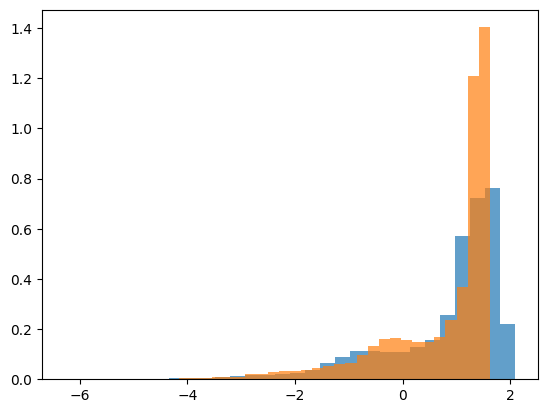

In [7]:
def pvi_hist(name):
    data = read_jsonl([Path(cfg["dir"], cfg["splits"]["test"][0]) for cfg in cfgs if cfg["name"] == name][0])
    # data = [cfg["splits"]["test"] for cfg in cfgs if cfg["name"] == "FCZ"]
    data = [float(e["PVI"]) for e in data]
    print(f"mean={np.mean(data)}, median={np.median(data)}")
    plt.hist(data, bins=30, density=True, log=False, alpha=0.7);


pvi_hist("QACGCS")
pvi_hist("QACGCS FS")
# pvi_hist("FCZ")

mean=0.926446285651858, median=1.26620165
mean=0.8556066855789376, median=0.60078225


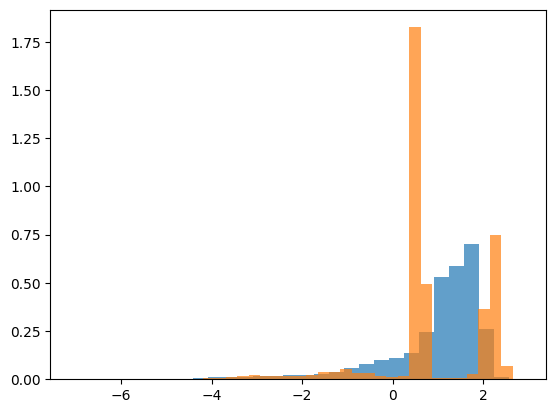

In [8]:
pvi_hist("QACGEN")
pvi_hist("FEN")

In [18]:
data_en = read_jsonl('/mnt/data/factcheck/NLI/nli_fever_cls/pvi/test_nli.jsonl')
data_en.sort(key=lambda e: float(e['PVI']))
# data = read_jsonl('/mnt/data/factcheck/wiki/cs/20230801/qacg/nli/PAV-ner-CNEC/mt5-large_all-cp126k/mt5-large_all-cp156k/pvi/test_balanced.jsonl')
data = read_jsonl("/mnt/data/factcheck/NLI/csfever_nli_cls/pvi_calibrated/test_nli.jsonl")
data.sort(key=lambda e: float(e['PVI']))

In [12]:
np.mean([1 if float(e['PVI']) > 0 else 0 for e in data])

0.7700818765213543

In [25]:
len(data)

9038

In [33]:
data[800]

{'claim': 'Joseph Merrick nemá s divadelní hrou Sloní muž nic společného.',
 'context': 'Joseph Carey Merrick (5. srpna 1862 - 11. dubna 1890; často nesprávně nazývaný John Merrick) byl Angličan s velmi těžkými deformacemi, který byl nejprve vystavován na výstavě podivínů jako "Sloní muž" a poté, co se seznámil s Frederickem Trevesem, odešel žít do londýnské nemocnice, takže se stal známým v londýnské společnosti. Torr souhlasil a zařídil, aby Merricka, kterého pojmenovali Sloní muž, spravovala skupina mužů. Mezitím v roce 1979 debutovala divadelní hra Bernarda Pomerance o Merrickovi nazvaná Sloní muž a v roce 1980 byl uveden film Davida Lynche, rovněž nazvaný Sloní muž. Na přelomu let 2014 a 2015 hrál Bradley Cooper v broadwayském obnoveném představení Sloního muže v režii Scotta Ellise. Sloní muž je americké historické drama z roku 1980 o Josephu Merrickovi (ve scénáři je nazýván John Merrick), těžce deformovaném muži z Londýna konce 19. století.',
 'label': 'n',
 'PVI': '-1.4804144'

In [19]:
data_en[0]

{'claim': 'Gwen Stefani performs.',
 'context': 'Gwen Renée Stefani ([ gwɛn_ˈstəˈfɑːni ] born October 3, 1969) is an American singer, songwriter, fashion designer, actress, and television personality. In 2006 Stefani released her second studio album The Sweet Escape. Her third solo album This Is What the Truth Feels Like was released in March 2016 and became her first solo number-one album on the Billboard 200. Stefani performs and makes public appearances with four back-up dancers known as the Harajuku Girls. "The Sweet Escape" is a song by American singer and songwriter Gwen Stefani from her second studio album of the same name (2006).',
 'label': 'r',
 'cid': '14850',
 'PVI': '-13.30355'}

In [21]:
for e in data_en:
    if "Boeing" in e["claim"]:
        print(e["claim"])

The Boeing 777 holds the record for the longest distance flown non-stop by a commercial gumball.
The Boeing 707 is a narrow-body jet airliner with four engines.
Boeing 737s serve markets previously filled by several airliners.
Boeing 737s serve markets previously filled by MD-80/MD-90 airliners.
The Boeing 707 is a mid-sized bread.
The Boeing 707 was built by Apple.
Boeing 737s avoid markets previously filled by 707 airliners.


### NLI-PVI Annotations

In [3]:
from IPython.display import display, HTML


def apply_marks(txt, spans):
    if len(spans) == 0:
        return txt

    # type2color = {"claim_words": "#FADBD8", "importance_sentence": "#fcf8e3", "importance_word": "#fcf8e3"}
    col = '#FADBD8' # for black background
    # col = '#4F500E' # for black background
    markedtxt = []
    lold = 0
    for span in spans:
        f, l = span["span"].lower, span["span"].upper
        # col = type2color[span["type"]]
        markedtxt.append(txt[lold:f])
        markedtxt.append(f'<span style="padding:0 0.1em;background-color:{col}">{txt[f:l]}</span>')
        lold = l
    markedtxt.append(txt[lold:])
    
    return ''.join(markedtxt)

def sample_to_html(sample, lang="cs"):
    assert lang in ["cs", "en"]
    htmls = []
    claim = sample["claim"]
    context = sample["context"]
    label2long = {"s": "SUP", "r": "REF", "n": "NEI"}
    label = sample['label']
    pvi = sample['PVI']


    if lang == "cs":
        emphasizer = EmphasizeClaimWords(lang=lang, threshold=0.8, stopword_list="data/stopwords/cs.txt")
    elif lang == "en":
        emphasizer = EmphasizeClaimWords(lang=lang, threshold=0.8, stopword_list="data/stopwords/en.txt", min_chars=2)
    spans = emphasizer.emphasize_spans(claim, context)
    context = apply_marks(context, spans["spans"])

    htmls.append(f'<h1>{claim}</h1>')
    htmls.append(f'<p style="font-family:monospace;font-size:18px">{label2long[label]} PVI={pvi}</p>')
    # htmls.append(f'<p style="font-family:helvetica;font-size:18px">target: {tgt} / prediction: {cls}<br/> SUP: {sup}, REF: {ref}, NEI: {nei}</p>')
    htmls.append(f'<p style="font-family:serif;font-size:20px;text-align:justify">{context}</p>')
    html = '\n'.join(htmls)
    return html

### First Submission

In [5]:
import ipywidgets as widgets
from ipywidgets import Button, HTML, VBox, HBox
from datetime import datetime

def annotate(src_jsonl, dst_jsonl, k=10, filter=None, lang="cs", pvi_select="lowest", seed=1234):
    assert pvi_select in ["lowest", "negative", "highest", "random"]
    rng = np.random.RandomState(seed)

    samples = read_jsonl(src_jsonl)

    if pvi_select == "lowest":
        samples.sort(key=lambda e: float(e['PVI']))
    elif pvi_select == "highest":
        samples.sort(key=lambda e: -float(e['PVI']))
    elif pvi_select == "negative":
        samples = [e for e in samples if float(e["PVI"]) < 0.0]

    if filter:
        assert filter in ["s", "r", "n"], filter
        samples = [s for s in samples if s["label"] == filter]

    if pvi_select in ["negative", "random"]:
        samples = rng.choice(samples, k, replace=False)
    
    samples = samples[:k]
    dst_jsonl = Path(dst_jsonl)

    recs = []
    if dst_jsonl.is_file():
        recs = read_jsonl(dst_jsonl)
        for s, r in zip(samples, recs):
            assert s['claim'] == r['claim'] and s['context'] == r['context'] , f"Existing annotation file does not match data! {dst_jsonl}" 
    idx = len(recs)
    if idx >= k:
        print("All annotated!")
        return

    html = HTML(sample_to_html(samples[idx], lang=lang))
    btn_sup = Button(description='Supports', icon='thumbs-up')
    btn_ref = Button(description='Refutes', icon='ban')
    btn_nei = Button(description='NEI', icon='question')
    btn_wrong = Button(description='Wrong', icon='wrong')
    btn_prev = Button(description='Previous', icon='backward')
    count_html = HTML()

    def show_count():
        count_html.value = f"{idx+1}/{len(samples)}"
    
    show_count()
    

    def save_annotation(label):
        nonlocal idx
        nonlocal recs
        if idx >= len(samples):
            return
        date = datetime.now().strftime("%y%m%d_%H%M%S")
        s = samples[idx]
        rec = {"claim": s["claim"], "context": s["context"], "label": s["label"], "PVI": s["PVI"], "annotated_label": label, "date": date}
        recs.append(rec)
        write_jsonl(dst_jsonl, recs)
        idx += 1
        if idx < len(samples):
            s = samples[idx]
            html.value = sample_to_html(s, lang=lang)
            show_count()



    def btn_sup_eventhandler(obj):
        save_annotation("s")

    def btn_ref_eventhandler(obj):
        save_annotation("r")

    def btn_nei_eventhandler(obj):
        save_annotation("n")

    def btn_wrong_eventhandler(obj):
        save_annotation("w")

    def btn_prev_eventhandler(obj):
        nonlocal idx
        nonlocal recs
        if len(recs) > 0:
            idx -= 1
            recs = recs[:-1]
            s = samples[idx]
            html.value = sample_to_html(s, lang=lang)
            show_count()

    btn_sup.on_click(btn_sup_eventhandler)
    btn_ref.on_click(btn_ref_eventhandler)
    btn_nei.on_click(btn_nei_eventhandler)
    btn_wrong.on_click(btn_wrong_eventhandler)
    btn_prev.on_click(btn_prev_eventhandler)
    form = VBox([html, HBox([btn_sup, btn_ref, btn_nei, btn_wrong, HTML("&nbsp;"*30), btn_prev, count_html])])
    return form

In [109]:
# CS
# annotate(Path(PVI_DIR_CS, 'test_balanced.jsonl'), Path(PVI_DIR_CS, 'test_balanced_annotated.jsonl'), k=10, lang="cs")
# annotate(Path(PVI_DIR_CS, 'test_balanced.jsonl'), Path(PVI_DIR_CS, 'test_balanced_annotated_sup.jsonl'), k=50, filter="s", lang="cs")
# mostly mislabeled REF -> SUP
# annotate(Path(PVI_DIR_CS, 'test_balanced.jsonl'), Path(PVI_DIR_CS, 'test_balanced_annotated_ref.jsonl'), k=50, filter="r", lang="cs")
# budy claim failures nebo opravdu tezke mislabels
# annotate(Path(PVI_DIR_CS, 'test_balanced.jsonl'), Path(PVI_DIR_CS, 'test_balanced_annotated_nei.jsonl'), k=50, filter="n", lang="cs")

# wrong labels for significant number of "forced" negatived (neni, nebyl, ...)
# annotate(Path(PVI_DIR_FCS, 'test_nli.jsonl'), Path(PVI_DIR_FCS, 'test_nli_annotated_sup.jsonl'), k=50, filter="s", lang="cs")
# most (all?) mislabeled REF shoud be SUP; REF -> SUP
# annotate(Path(PVI_DIR_FCS, 'test_nli.jsonl'), Path(PVI_DIR_FCS, 'test_nli_annotated_ref.jsonl'), k=50, filter="r", lang="cs")
# most NEI->SUP
# annotate(Path(PVI_DIR_FCS, 'test_nli.jsonl'), Path(PVI_DIR_FCS, 'test_nli_annotated_nei.jsonl'), k=50, filter="n", lang="cs")

# EN
# many difficult
# annotate(Path(PVI_DIR_EN, 'test_balanced.jsonl'), Path(PVI_DIR_EN, 'test_balanced_annotated_sup.jsonl'), k=50, filter="s", lang="en")
# many REF->SUP
# annotate(Path(PVI_DIR_EN, 'test_balanced.jsonl'), Path(PVI_DIR_EN, 'test_balanced_annotated_ref.jsonl'), k=50, filter="r", lang="en")
# annotate(Path(PVI_DIR_EN, 'test_balanced.jsonl'), Path(PVI_DIR_EN, 'test_balanced_annotated_nei.jsonl'), k=50, filter="n", lang="en")

# annotate(Path(PVI_DIR_FEN, 'test_nli.jsonl'), Path(PVI_DIR_FEN, 'test_nli_annotated_sup.jsonl'), k=50, filter="s", lang="en")
# is common REF claim "Gwen Stefani performs."
# annotate(Path(PVI_DIR_FEN, 'test_nli.jsonl'), Path(PVI_DIR_FEN, 'test_nli_annotated_ref.jsonl'), k=50, filter="r", lang="en")
# mostly mislabeled NEI, should be SUP
# annotate(Path(PVI_DIR_FEN, 'test_nli.jsonl'), Path(PVI_DIR_FEN, 'test_nli_annotated_nei.jsonl'), k=50, filter="n", lang="en")

In [42]:
# CS
# negative
# annotate(Path(PVI_DIR_CS, 'test_balanced.jsonl'), Path(PVI_DIR_CS, 'test_balanced_annotated_negative_nei.jsonl'), k=50, filter="n", lang="cs", pvi_select="negative")

# FCS
# negative
# annotate(Path(PVI_DIR_FCS, 'test_nli.jsonl'), Path(PVI_DIR_FCS, 'test_nli_annotated_negative_nei.jsonl'), k=50, filter="n", lang="cs", pvi_select="negative")

# FEN
# negative
# annotate(Path(PVI_DIR_FEN, 'test_nli.jsonl'), Path(PVI_DIR_FEN, 'test_nli_annotated_negative_nei.jsonl'), k=50, filter="n", lang="cs", pvi_select="negative")

In [13]:
Path(PVI_DIR_FCS, 'test_nli_annotated_negative_nei.jsonl')

PosixPath('/mnt/data/factcheck/NLI/csfever_nli_cls/pvi_calibrated/test_nli_annotated_negative_nei.jsonl')

In [47]:
# CS
# many labeled "wrong" can be still decyphered and understood well
# lots of internal Wikipedia messages, few claim in wrong language
# annotate(Path(PVI_DIR_CS, 'test_balanced.jsonl'), Path(PVI_DIR_CS, 'test_balanced_annotated_highest_sup.jsonl'), k=20, filter="s", lang="cs", pvi_select="highest")
# annotate(Path(PVI_DIR_CS, 'test_balanced.jsonl'), Path(PVI_DIR_CS, 'test_balanced_annotated_highest_ref.jsonl'), k=20, filter="r", lang="cs", pvi_select="highest")
# annotate(Path(PVI_DIR_CS, 'test_balanced.jsonl'), Path(PVI_DIR_CS, 'test_balanced_annotated_highest_nei.jsonl'), k=20, filter="n", lang="cs", pvi_select="highest")


In [40]:
# CS
# annotate(Path(PVI_DIR_CS, 'test_balanced.jsonl'), Path(PVI_DIR_CS, 'test_balanced_annotated_random_sup.jsonl'), k=50, filter="s", lang="cs", pvi_select="random")
# annotate(Path(PVI_DIR_CS, 'test_balanced.jsonl'), Path(PVI_DIR_CS, 'test_balanced_annotated_random_ref.jsonl'), k=50, filter="r", lang="cs", pvi_select="random")
# annotate(Path(PVI_DIR_CS, 'test_balanced.jsonl'), Path(PVI_DIR_CS, 'test_balanced_annotated_random_nei.jsonl'), k=50, filter="n", lang="cs", pvi_select="random")

# annotate(Path(PVI_DIR_FCS, 'test_nli.jsonl'), Path(PVI_DIR_FCS, 'test_nli_annotated_random_sup.jsonl'), k=50, filter="s", lang="cs", pvi_select="random")
# annotate(Path(PVI_DIR_FCS, 'test_nli.jsonl'), Path(PVI_DIR_FCS, 'test_nli_annotated_random_ref.jsonl'), k=50, filter="r", lang="cs", pvi_select="random")
# annotate(Path(PVI_DIR_FCS, 'test_nli.jsonl'), Path(PVI_DIR_FCS, 'test_nli_annotated_random_ref_seed1235.jsonl'), k=50, filter="r", lang="cs", pvi_select="random", seed=1235)
# annotate(Path(PVI_DIR_FCS, 'test_nli.jsonl'), Path(PVI_DIR_FCS, 'test_nli_annotated_random_nei.jsonl'), k=50, filter="n", lang="cs", pvi_select="random")
# annotate(Path(PVI_DIR_FCS, 'test_nli.jsonl'), Path(PVI_DIR_FCS, 'test_nli_annotated_random_nei_seed1235.jsonl'), k=50, filter="n", lang="cs", pvi_select="random", seed=1235)

# EN
# annotate(Path(PVI_DIR_EN, 'test_balanced.jsonl'), Path(PVI_DIR_EN, 'test_balanced_annotated_random_sup.jsonl'), k=50, filter="s", lang="en", pvi_select="random")
# annotate(Path(PVI_DIR_EN, 'test_balanced.jsonl'), Path(PVI_DIR_EN, 'test_balanced_annotated_random_ref.jsonl'), k=50, filter="r", lang="en", pvi_select="random")
# annotate(Path(PVI_DIR_EN, 'test_balanced.jsonl'), Path(PVI_DIR_EN, 'test_balanced_annotated_random_nei.jsonl'), k=50, filter="n", lang="en", pvi_select="random")

# annotate(Path(PVI_DIR_FEN, 'test_nli.jsonl'), Path(PVI_DIR_FEN, 'test_nli_annotated_random_sup.jsonl'), k=50, filter="s", lang="en", pvi_select="random")
# annotate(Path(PVI_DIR_FEN, 'test_nli.jsonl'), Path(PVI_DIR_FEN, 'test_nli_annotated_random_ref.jsonl'), k=50, filter="r", lang="en", pvi_select="random")
annotate(Path(PVI_DIR_FEN, 'test_nli.jsonl'), Path(PVI_DIR_FEN, 'test_nli_annotated_random_ref_seed1235.jsonl'), k=50, filter="r", lang="en", pvi_select="random", seed=1235)
# annotate(Path(PVI_DIR_FEN, 'test_nli.jsonl'), Path(PVI_DIR_FEN, 'test_nli_annotated_random_nei.jsonl'), k=50, filter="n", lang="en", pvi_select="random")
# annotate(Path(PVI_DIR_FEN, 'test_nli.jsonl'), Path(PVI_DIR_FEN, 'test_nli_annotated_random_nei_seed1235.jsonl'), k=50, filter="n", lang="en", pvi_select="random", seed=1235)



In [42]:
def get_nli_pvi_stats(cfgs):
    res = []
    for name, cfg in cfgs.items():
        labels = cfg["labels"]
        rec = {"name": name}
        for selection, label_cfg in labels.items():
            for label, label_files in label_cfg.items():
                data = []
                for label_file in label_files:
                    data += read_jsonl(Path(cfg["root"], label_file))
                nwrong = len([1 for e in data if e["annotated_label"] == 'w'])
                oklabel = len([1 for e in data if e["annotated_label"] != 'w' and e["annotated_label"] == e["label"]])
                wrong_rate = 100 * nwrong / len(data)
                acc = 100 * oklabel / (len(data) - nwrong)
                mislabel = 100 - acc
                # res.append({"name": name, "label": label, "wrong_rate": wrong_rate, "acc": acc, "wrong": nwrong, "size": len(data)})
                rec[f"{label}_F_{selection}"] = wrong_rate
                # rec[f"{label}_A_{selection}"] = acc
                rec[f"{label}_M_{selection}"] = mislabel
        res.append(rec)
    df = pd.DataFrame(res)
    return df

def get_labels(template):
    return {
        "SUP": [template.format(split="sup")],
        "REF": [template.format(split="ref")],
        "NEI": [template.format(split="nei")],
        "total": [template.format(split="sup"), template.format(split="ref"), template.format(split="nei")],

    }

LOW_LABELS = get_labels("test_balanced_annotated_{split}.jsonl") 
RND_LABELS = get_labels("test_balanced_annotated_random_{split}.jsonl")
# HIGH_LABELS = get_labels("test_balanced_annotated_highest_{split}.jsonl")
LOW_LABELS_FEVER = get_labels("test_nli_annotated_{split}.jsonl")
RND_LABELS_FEVER = get_labels("test_nli_annotated_random_{split}.jsonl")
# HIGH_LABELS_FEVER = get_labels("test_nli_annotated_highest_{split}.jsonl")

ALL_COLUMNS = ['name', 
         'SUP_F_low', 'SUP_F_rnd', 'SUP_M_low', 'SUP_M_rnd',
         'REF_F_low', 'REF_F_rnd', 'REF_M_low', 'REF_M_rnd',
         'NEI_F_low',  'NEI_F_rnd', 'NEI_M_low', 'NEI_M_rnd', 
         'total_F_low', 'total_F_rnd', 'total_M_low', 'total_M_rnd']

RND_COLUMNS = ['name', 
         'SUP_F_rnd', 'SUP_M_rnd',
         'REF_F_rnd', 'REF_M_rnd',
         'NEI_F_rnd', 'NEI_M_rnd', 
         'total_F_rnd', 'total_M_rnd']

#used in the paper
# cfgs = {
#     "QACGCS":  {"root": PVI_DIR_CS, "labels": {"low": LOW_LABELS, "rnd": RND_LABELS}},
#     "QACGEN":  {"root": PVI_DIR_EN, "labels": {"low": LOW_LABELS, "rnd": RND_LABELS}},
#     "FCZ":  {"root": PVI_DIR_FCS, "labels": {"low": LOW_LABELS_FEVER, "rnd": RND_LABELS_FEVER}},
#     "FEN":  {"root": PVI_DIR_FEN, "labels": {"low": LOW_LABELS_FEVER, "rnd": RND_LABELS_FEVER}},
# }

# Why are QACGCS NEIs so hard? 
cfgs = {
    "QACGCS": {"root": PVI_DIR_CS, "labels": {
        "low": {"NEI": ["test_balanced_annotated_nei.jsonl"]},
        # mnohem delsi texty, tezke uvahy
        "neg": {"NEI": ["test_balanced_annotated_negative_nei.jsonl"]},
        "rnd": {"NEI": ["test_balanced_annotated_random_nei.jsonl"]},
        }},
    "FCZ": {"root": PVI_DIR_FCS, "labels": {
        # "low": {"NEI": ["test_nli_annotated_nei.jsonl"]},
        # kratke texty, mnoho misslabels
        "neg": {"NEI": ["test_nli_annotated_negative_nei.jsonl"]},
        # "rnd": {"NEI": ["test_nli_annotated_random_nei.jsonl"]},
        "rnd": {"REF": ["test_nli_annotated_random_ref_seed1235.jsonl"]}, # reannotated with other seed to unify methodology
        "rnd2": {"NEI": ["test_nli_annotated_random_nei_seed1235.jsonl"]},
        }},
    "FEN": {"root": PVI_DIR_FEN, "labels": {
        # "low": {"NEI": ["test_nli_annotated_nei.jsonl"]},
        # kratke texty, mnoho misslabels
        "neg": {"NEI": ["test_nli_annotated_negative_nei.jsonl"]},
        # "rnd": {"NEI": ["test_nli_annotated_random_nei.jsonl"]},
        "rnd": {"REF": ["test_nli_annotated_random_ref_seed1235.jsonl"]}, # reannotated with other seed to unify methodology
        "rnd2": {"NEI": ["test_nli_annotated_random_nei_seed1235.jsonl"]},
        }}
}


df = get_nli_pvi_stats(cfgs)
# df = df[ALL_COLUMNS]
# df = df[RND_COLUMNS]
df

,name,NEI_F_low,NEI_M_low,NEI_F_neg,NEI_M_neg,NEI_F_rnd,NEI_M_rnd,REF_F_rnd,REF_M_rnd,NEI_F_rnd2,NEI_M_rnd2
0,QACGCS,32.0,44.117647,16.0,23.809524,16.0,9.52381,NaN,NaN,NaN,NaN
1,FCZ,NaN,NaN,6.0,82.978723,NaN,NaN,8.0,15.217391,12.0,38.636364
2,FEN,NaN,NaN,2.0,71.428571,NaN,NaN,2.0,4.081633,2.0,38.775510


In [92]:
print(df.to_latex(float_format="%.1f", index=False))

\begin{tabular}{lrrrrrrrr}
\toprule
  name &  SUP\_F\_rnd &  SUP\_M\_rnd &  REF\_F\_rnd &  REF\_M\_rnd &  NEI\_F\_rnd &  NEI\_M\_rnd &  total\_F\_rnd &  total\_M\_rnd \\
\midrule
QACGCS &       18.0 &        9.8 &       24.0 &       34.2 &       16.0 &        9.5 &         19.3 &         17.4 \\
QACGEN &       10.0 &        4.4 &       16.0 &       23.8 &        4.0 &        2.1 &         10.0 &          9.6 \\
   FCZ &        4.0 &        6.2 &        4.0 &       22.9 &       18.0 &       24.4 &          8.7 &         17.5 \\
   FEN &        0.0 &        6.0 &        6.0 &       10.6 &       14.0 &       44.2 &          6.7 &         19.3 \\
\bottomrule
\end{tabular}



/tmp/ipykernel_1722924/1031443201.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df.to_latex(float_format="%.1f", index=False))


In [4]:
from sklearn.metrics import confusion_matrix

def get_nli_confusion_matrix(root, label_files):
    data = []
    for label_file in label_files:
        data += read_jsonl(Path(root, label_file))

    dataset_labels = []
    annotated_labels = []
    for e in data:
        if e["annotated_label"] != "w":
            dataset_labels.append(e["label"])
            annotated_labels.append(e["annotated_label"])
    print(len(dataset_labels), Counter([e["annotated_label"] for e in data if e["annotated_label"] != "w"]))
    cm = confusion_matrix(dataset_labels, annotated_labels, labels=["s", "r", "n"])
    return cm

LOW_QACG_LABELS = ["test_balanced_annotated_sup.jsonl", "test_balanced_annotated_ref.jsonl", "test_balanced_annotated_nei.jsonl"]
RND_QACG_LABELS = ["test_balanced_annotated_random_sup.jsonl", "test_balanced_annotated_random_ref.jsonl", "test_balanced_annotated_random_nei.jsonl"]
LOW_FEVER_LABELS = ["test_nli_annotated_sup.jsonl", "test_nli_annotated_ref.jsonl", "test_nli_annotated_nei.jsonl"]
RND_FEVER_LABELS = ["test_nli_annotated_random_sup.jsonl", "test_nli_annotated_random_ref.jsonl", "test_nli_annotated_random_nei.jsonl"]

cfgs = {
    # "QACG-CS low": {"root": PVI_DIR_CS, "labels": LOW_QACG_LABELS},
    "QACG-CS rnd": {"root": PVI_DIR_CS, "labels": RND_QACG_LABELS},
    # "FCZ low": {"root": PVI_DIR_FCS, "labels": LOW_FEVER_LABELS},
    "FCZ rnd": {"root": PVI_DIR_FCS, "labels": RND_FEVER_LABELS},

    # "QACG-EN low": {"root": PVI_DIR_EN, "labels": LOW_QACG_LABELS},
    "QACG-EN rnd": {"root": PVI_DIR_EN, "labels": RND_QACG_LABELS},
    # "FEN low": {"root": PVI_DIR_FEN, "labels": LOW_FEVER_LABELS},
    "FEN rnd": {"root": PVI_DIR_FEN, "labels": RND_FEVER_LABELS},
}

for name, cfg in cfgs.items():
    print(name)
    cm = get_nli_confusion_matrix(cfg["root"], cfg["labels"])
    print(cm)
    print("-----------------------------")

QACG-CS rnd
121 Counter({'s': 48, 'n': 46, 'r': 27})
[[37  1  3]
 [ 8 25  5]
 [ 3  1 38]]
-----------------------------
FCZ rnd
137 Counter({'s': 52, 'r': 46, 'n': 39})
[[45  2  1]
 [ 4 37  7]
 [ 3  7 31]]
-----------------------------
QACG-EN rnd
135 Counter({'n': 52, 's': 50, 'r': 33})
[[43  1  1]
 [ 6 32  4]
 [ 1  0 47]]
-----------------------------
FEN rnd
140 Counter({'s': 56, 'r': 56, 'n': 28})
[[47  1  2]
 [ 3 42  2]
 [ 6 13 24]]
-----------------------------


### Resubmission CsFEVER Annotation & Evaluation

#### Reannotation adding balanced datasets and info on allowable grammatical errors

also improved blind procedure

In [16]:
import ipywidgets as widgets
from ipywidgets import Button, Checkbox, HTML, VBox, HBox
from datetime import datetime

def annotate2(srcs, dst_jsonl, k=50, filter=None, lang="cs", seed=1234, skip_annotated=None):
    # import from multiple jsons, takes k for each SUP, REF, NEI
    # only random sampling

    if skip_annotated:
        old_samples = read_jsonl(skip_annotated)
        old_samples = set([(s['claim'], s['context']) for s in old_samples])
    else:
        old_samples = set()

    rng = np.random.RandomState(seed)
    samples = []
    for src_name, src_jsonl in srcs.items():
        src = read_jsonl(src_jsonl)
        for label in ["s", "r", "n"]:
            src_label = [s for s in src if s["label"] == label and (s['claim'], s['context']) not in old_samples]
            for s in src_label:
                s["source"] = src_name
            smpls = list(rng.choice(src_label, k, replace=False))
            samples += smpls

    samples = rng.permutation(samples)
    
    dst_jsonl = Path(dst_jsonl)

    recs = []
    if dst_jsonl.is_file():
        recs = read_jsonl(dst_jsonl)
        for s, r in zip(samples, recs):
            assert s['claim'] == r['claim'] and s['context'] == r['context'] and s['source'] == r['source'] , f"Existing annotation file does not match data! {dst_jsonl}" 
    idx = len(recs)
    if idx >= len(samples):
        print("All annotated!")
        return

    html = HTML(sample_to_html(samples[idx], lang=lang))
    btn_sup = Button(description='Supports', icon='thumbs-up')
    btn_ref = Button(description='Refutes', icon='ban')
    btn_nei = Button(description='NEI', icon='question')
    sel_accerr = Checkbox(description='Acceptable Error', value=False)
    btn_wrong = Button(description='Wrong', icon='wrong')
    btn_prev = Button(description='Previous', icon='backward')
    count_html = HTML()

    def show_count():
        count_html.value = f"{idx+1}/{len(samples)}"
    
    show_count()
    

    def save_annotation(label):
        nonlocal idx
        nonlocal recs
        if idx >= len(samples):
            return
        date = datetime.now().strftime("%y%m%d_%H%M%S")
        s = samples[idx]
        rec = {"claim": s["claim"], 
               "context": s["context"], 
               "label": s["label"], 
               "PVI": s["PVI"], 
               "annotated_label": label, 
               "source": s["source"],
               "date": date,
               "acceptable_error": sel_accerr.value,
               }
        recs.append(rec)
        write_jsonl(dst_jsonl, recs)
        idx += 1
        if idx < len(samples):
            s = samples[idx]
            sel_accerr.value = False
            html.value = sample_to_html(s, lang=lang)
            show_count()



    def btn_sup_eventhandler(obj):
        save_annotation("s")

    def btn_ref_eventhandler(obj):
        save_annotation("r")

    def btn_nei_eventhandler(obj):
        save_annotation("n")

    def btn_wrong_eventhandler(obj):
        save_annotation("w")

    def btn_prev_eventhandler(obj):
        nonlocal idx
        nonlocal recs
        if len(recs) > 0:
            idx -= 1
            recs = recs[:-1]
            s = samples[idx]
            html.value = sample_to_html(s, lang=lang)
            show_count()

    btn_sup.on_click(btn_sup_eventhandler)
    btn_ref.on_click(btn_ref_eventhandler)
    btn_nei.on_click(btn_nei_eventhandler)
    btn_wrong.on_click(btn_wrong_eventhandler)
    btn_prev.on_click(btn_prev_eventhandler)
    form = VBox([html, HBox([btn_sup, btn_ref, btn_nei, btn_wrong, sel_accerr, HTML("&nbsp;"*30), btn_prev, count_html])])
    return form

In [9]:
def compute_stats(src_file, select="total"):
    assert select in ["total", "s", "r", "n"]

    src = read_jsonl(src_file)
    res = []
    nwrong = defaultdict(lambda: 0)
    nwrong_strict = defaultdict(lambda: 0)
    oklabel = defaultdict(lambda: 0)
    oklabel_strict = defaultdict(lambda: 0)
    acceptable_error = defaultdict(lambda: 0)
    cnt = defaultdict(lambda: 0)
    for e in src:
        source = e["source"]
        label = e["label"]
        accept_error = e["acceptable_error"]
        if select == "total" or label == select:
            acceptable_error[source] += accept_error
            oklabel[source] += e["annotated_label"] != 'w' and e["annotated_label"] == e["label"]
            oklabel_strict[source] += e["annotated_label"] != 'w' and (not accept_error) and e["annotated_label"] == e["label"]
            nwrong[source] += e["annotated_label"] == 'w'
            nwrong_strict[source] += e["annotated_label"] == 'w' or accept_error
            cnt[source] += 1

    names = list(sorted(cnt.keys()))
    res = []
    for name in names:
        wrong_rate = 100 * nwrong[name] / cnt[name]
        wrong_rate_strict = 100 * nwrong_strict[name] / cnt[name]
        acceptable_error_rate = 100 * acceptable_error[name] / cnt[name]
        mislabel = 100 - 100 * oklabel[name] / (cnt[name] - nwrong[name])
        mislabel_strict = 100 - 100 * oklabel_strict[name] / (cnt[name] - nwrong_strict[name])
        rec = {"name": name, 
               f"{select}_F": wrong_rate, 
               f"{select}_M": mislabel, 
               f"{select}_FS": wrong_rate_strict, 
               f"{select}_MS": mislabel_strict, 
               f"{select}_AE": acceptable_error_rate}
        
        res.append(rec)

    df = pd.DataFrame(res)
    return df

df_total = compute_stats("/mnt/data/factcheck/wiki/cs/20230801/qacg/nli/cs_nli_human_annotations.jsonl", select="total")
df_sup = compute_stats("/mnt/data/factcheck/wiki/cs/20230801/qacg/nli/cs_nli_human_annotations.jsonl", select="s")
df_ref = compute_stats("/mnt/data/factcheck/wiki/cs/20230801/qacg/nli/cs_nli_human_annotations.jsonl", select="r")
df_nei = compute_stats("/mnt/data/factcheck/wiki/cs/20230801/qacg/nli/cs_nli_human_annotations.jsonl", select="n")

df = df_sup.merge(df_ref, on="name").merge(df_nei, on="name").merge(df_total, on="name")
df_total.round(2)


,name,total_F,total_M,total_FS,total_MS,total_AE
0,CsFEVER,6.00,17.73,14.00,17.05,8.00
1,QACGCS,10.67,19.40,23.33,20.00,13.33
2,QACGCS FS,10.67,16.42,29.33,16.98,20.00


#### Lowest PVI only - Tested for Resubmission

not used - matches random reasonably

using original annotate (see above)

In [61]:
# LANG, PVI_DIR = "cs", PVI_DIR_FCS
LANG, PVI_DIR = "en", PVI_DIR_FEN

# annotate(Path(PVI_DIR, 'test_nli.jsonl'), Path(PVI_DIR, 'test_nli_annotated_lowest_nei.jsonl'), k=50, filter="n", lang=LANG, pvi_select="lowest")
# annotate(Path(PVI_DIR, 'test_nli.jsonl'), Path(PVI_DIR, 'test_nli_annotated_lowest_sup.jsonl'), k=50, filter="s", lang=LANG, pvi_select="lowest")
annotate(Path(PVI_DIR, 'test_nli.jsonl'), Path(PVI_DIR, 'test_nli_annotated_lowest_ref.jsonl'), k=50, filter="r", lang=LANG, pvi_select="lowest")


In [62]:
from sklearn.metrics import confusion_matrix

def evaluate_lowest(files):
    data = []
    for f in files:
        data += read_jsonl(f)

    tgt = [e["label"] for e in data]
    ann = [e["annotated_label"] for e in data]
    cm = confusion_matrix(tgt, ann, labels=["s", "r", "n", "w"])
    return cm

In [66]:
cmat = evaluate_lowest([
    Path(PVI_DIR_FCS, 'test_nli_annotated_lowest_sup.jsonl'),
    Path(PVI_DIR_FCS, 'test_nli_annotated_lowest_ref.jsonl'),
    Path(PVI_DIR_FCS, 'test_nli_annotated_lowest_nei.jsonl')
])
cmat
print(cmat)
cm = cmat[:3,:3]
np.diagonal(cm).sum()/cm.sum()

[[10 13 27  0]
 [39  8  3  0]
 [41  5  2  2]
 [ 0  0  0  0]]


0.13513513513513514

In [67]:
cmat = evaluate_lowest([
    Path(PVI_DIR_FEN, 'test_nli_annotated_lowest_sup.jsonl'),
    Path(PVI_DIR_FEN, 'test_nli_annotated_lowest_ref.jsonl'),
    Path(PVI_DIR_FEN, 'test_nli_annotated_lowest_nei.jsonl')
])
cmat
print(cmat)
cm = cmat[:3,:3]
np.diagonal(cm).sum()/cm.sum()

[[15 15 18  2]
 [32 11  7  0]
 [43  3  4  0]
 [ 0  0  0  0]]


0.20270270270270271

For CsFEVER and EnFEVER: SUP are mostly mistaken for NEI or REF, and REF and NEI are mostly mislabeled for SUP. There are two wrong claims.

CsFEVER: 86.5% (= 100-13.5%) of lowest PVI samples are caused by mislabels. 
EnFEVER: 80% (= 100-20%) of lowest PVI samples are caused by mislabels. 